Author: yanjun zhang
## Concise
## 1: Start

Source from book "Abali - 2017 - Computational Reality" P119

import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}")


DOLFINx version: 0.8.0


1: Total tims is  19.88 s
2: Total numb steps is  249


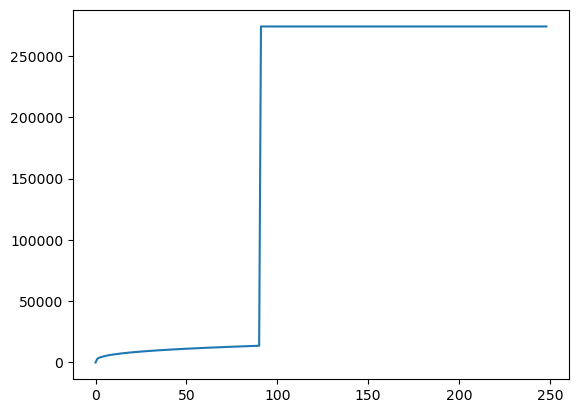

In [2]:
# import basic
import pyvista
import ufl
import dolfinx
import time
import sys
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

# import speciail library
from dolfinx.fem.petsc import (
    LinearProblem,
    assemble_vector,
    assemble_matrix,
    create_vector,
    apply_lifting,
    set_bc,
)
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (
    Constant,
    dirichletbc,
    Function,
    FunctionSpace,
    form,
    locate_dofs_topological,
)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import locate_entities, locate_entities_boundary, meshtags
from ufl import (
    SpatialCoordinate,
    TestFunction,
    TrialFunction,
    dx,
    grad,
    inner,
    Measure,
    dot,
    FacetNormal,
)
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from petsc4py import PETSc
from mpi4py import MPI

# import own functions


# calculate how long time the simulation it is
start_time = time.time()

# mesh-size, contact area coefficient
mesh_min = 3
mesh_max = 20
c_contact = 1

# Each time step rotation angular, and acc during lag, 1 is full acc, 0 is no acc.
angular_r = 224
v_vehicle = 160
c_acc = 1

def vehicle_initial(angular_r, v_vehicle, c_contact, c_acc):
    import numpy as np
    v_ini = v_vehicle/3.6   /   (920/2/1000) 
    # D_wheel = 920 mm, v = D_wheel /2 /1000 * v_ini *3.6   # km/h
    # Start time, Final time  
    t = 0
    t_brake = 20
    t_lag = 4
    # rubbing element radius, Contact area 
    r_rub = 18.8
    S_rub_circle = r_rub**2 * c_contact
    S_total = S_rub_circle * np.pi * 18  #mm2
    # initial and brake pad temperature
    Ti = 60
    Tm = 60
    # density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
    t_u = 1e3 # m to mm
    rho = 7850 /(t_u**3)
    c = 462
    k = 48 / t_u
    # mu, P_brake,  r_disc , heat_distribution  
    mu = 0.376
    P_initial = 274000
    r_disc = 0.25
    heat_distribution = 0.88
    # calculate total num_steps
    if c_acc == 1:  # constant acc for the whole process
        acc = v_ini/t_brake
        v_lag_end = (v_ini - (acc *t_lag) )   
        angular_r_rad = angular_r/180*np.pi  
        dt_lag = angular_r_rad  /  ( ( v_ini + v_lag_end  ) /2 )
        n_lag = round (t_lag / dt_lag) + 1 
        dt_a_lag = angular_r_rad  /  ( v_lag_end /2 )
        n_a_lag =  round ( (t_brake - t_lag) / dt_a_lag ) + 1
        num_steps = n_lag + n_a_lag
        dt = []
        v_angular = [v_ini]
        for i in range(num_steps):
            dt.append ( angular_r_rad / v_angular[i] )
            v_angular.append (  v_ini- sum(dt) * acc )           
        P = []
        for i in range(num_steps):
            if i <= n_lag:
                P.append( P_initial/ n_lag * (i ** (1/3)) )
            else:
                P.append( P_initial) 
    # S_or is the original brake pad rubbing area, 200 cm2. 
    S_or = 200
    S_new = S_total/100 #mm2 to cm2
    # g is the heat source,unit is w/mm2 
    g = []
    for i in range(num_steps):
        g.append ( mu * P[i] * v_angular[i] * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) )
        
    #  h is the heat convection coefficient, unit is W/mm2 K  
    h = 7.75e-5
    # radiation is the radiation heat coefficient, unit is W/mm2 K
    # stefan-Boltzmann constant theta = 5.67*10e-8 w/m2 k-4,   0.64 is the emmissivity
    radiation = 5.670*(10e-8)/(t_u**2)  * 0.64

    return dt,P,g,num_steps,h,radiation,v_angular,Ti,Tm,S_rub_circle,t,rho,c,k,t_brake,S_total
    
# calling local functions to get all parameters
(   dt,  P,    g,    num_steps,    h,    radiation,    v_angular,    Ti,    Tm,    S_rub_circle,    t,
    rho,    c,    k,    t_brake,    S_total,) = vehicle_initial (angular_r, v_vehicle, c_contact, c_acc)

print("1: Total tims is ", round(sum(dt), 2), "s")
print("2: Total numb steps is ", num_steps)



plt.plot(P)



In [3]:
from disc_f import *

## 2: Mesh

In [4]:
######################################  mesh  ###################################3
mesh_name = f"{mesh_min}-{mesh_max}"
mesh_filename1 = "m-{}.msh".format(mesh_name)
mesh_filename2 = "m-{}".format(mesh_name)

if os.path.exists(mesh_filename1):
    # Run this command if the file exists
    print(f"The file '{mesh_filename1}' exists, start creat now:")
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

else:
    # Run this command if the file does not exist
    print(f"The file '{mesh_filename1}' does not exist, start building:")
    mesh_brake_disc(mesh_min, mesh_max, mesh_filename2)
    domain, cell_markers, facet_markers = gmshio.read_from_msh(
        mesh_filename1, MPI.COMM_WORLD, 0, gdim=3
    )

# Define variational problem, CG is Lagrabge
V = fem.functionspace(domain, ("CG", 1))


# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs=[])
    return problem.solve()


# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V, DG is discontinuous Lagrange
Q = fem.functionspace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init, V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 50))
bc = fem.dirichletbc(
    PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V
)
np.set_printoptions(threshold=np.inf)

import meshio

mesh1 = meshio.read(mesh_filename1)
total_elements = sum(len(cells.data) for cells in mesh1.cells)

The file 'm-3-20.msh' exists, start creat now:
Info    : Reading 'm-3-20.msh'...
Info    : 168 entities
Info    : 2532 nodes
Info    : 8476 elements
Info    : Done reading 'm-3-20.msh'



## 3: Setup 


In [5]:
# create xdmf file, for paraview
xdmf_name = "T-s-{}-d-{}-{}-c-{}-e-{}.xdmf".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
h5_name = "T-s-{}-d-{}-{}-c-{}-e-{}.h5".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
xdmf = io.XDMFFile(domain.comm, xdmf_name, "w")
xdmf.write_mesh(domain)

# Create boundary condition
x_co, y_co = get_rub_coordinate()

common_indices3, facet_markers3, sorted_indices3 = target_facets(
    domain, x_co, y_co, S_rub_circle
)

facet_tag = meshtags(
    domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
)
ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

## 4: Variational equation


In [6]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init, V)
t = 0
xdmf.write_function(uh, t)

# u = trial function, solution what we want to know
u = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (
    (rho * c) / dt[0] * inner(u, v) * dx
    + k * inner(grad(u), grad(v)) * dx
    + h * inner(u, v) * ds(200)
    + radiation * inner(u**4, v) * ds(200)
    - (
        inner(f, v) * dx
        + (rho * c) / dt[0] * inner(u_n, v) * dx
        + h * Tm * v * ds(200)
        + radiation * (Tm**4) * v * ds(200)
    )
)


for i in list(range(1, 19)):
    # before 2024/5/16
    #F += -k * dot(grad(u) * v, n_vector) * ds(10 * i) - inner(g[0], v) * ds(10 * i)
    ## new start 2024/5/16, friction points do not have convection heat + heat input
    F += ( 
          + inner(g[0], v) * ds(10 * i) 
          - h * inner( u, v) * ds(10 * i)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * i) 
         )

problem = NonlinearProblem(F, u, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(u)
assert converged


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl

pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()

gif_name = "T-s-{}-d-{}-{}-c-{}-e-{}.gif".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements)

plotter.open_gif(gif_name, fps=30)
grid.point_data["Temperature"] = u.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(
    title_font_size=25,
    label_font_size=20,
    color="black",
    position_x=0.1,
    position_y=0.8,
    width=0.8,
    height=0.1,
)
renderer = plotter.add_mesh(
    warped,
    show_edges=True,
    lighting=False,
    cmap=viridis,
    scalar_bar_args=sargs,
    # clim=[0, max(uh.x.array)])
    clim=[0, 200],
)

2024-09-05 20:17:30.560 (   7.396s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:30.574 (   7.409s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:30.579 (   7.414s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.0115457 (tol = 1e-10) r (rel) = 3.82417e-06(tol = 1e-06)
2024-09-05 20:17:30.584 (   7.420s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:30.588 (   7.423s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 4.73191e-08 (tol = 1e-10) r (rel) = 1.5673e-11(tol = 1e-06)
2024-09-05 20:17:30.588 (   7.423s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 14 linear solver iterations.


## 5: Solution


In [7]:
T_array = [(0, [Ti for _ in range(len(u.x.array))])]
total_degree = 0

for i in range(num_steps):
    t += dt[i]

    x_co, y_co = rub_rotation(x_co, y_co, angular_r)  # update the location
    total_degree += angular_r  # Incrementing degree by 10 in each step

    sys.stdout.write("\r1: Rotation has applied for {} degree. ".format(total_degree))
    sys.stdout.write("2: Current time is " + str(round(t, 1)) + " s. ")
    sys.stdout.write("3: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    common_indices3, facet_markers3, sorted_indices3 = target_facets(
        domain, x_co, y_co, S_rub_circle
    )
    facet_tag = meshtags(
        domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3]
    )
    ds = Measure("ds", domain=domain, subdomain_data=facet_tag)

    F = (
        (rho * c) / dt[i] * inner(u, v) * dx
        + k * inner(grad(u), grad(v)) * dx
        + h * inner(u, v) * ds(200)
        + radiation * inner(u**4, v) * ds(200)
        - (
            inner(f, v) * dx
            + (rho * c) / dt[i] * inner(u_n, v) * dx
            + h * Tm * v * ds(200)
            + radiation * (Tm**4) * v * ds(200)
        )
    )

    for j in list(range(1, 19)):
        #F += -k * dot(grad(u) * v, n_vector) * ds(10 * j) - inner(g[i], v) * ds(10 * j)
        F += ( 
          - inner(g[i], v) * ds(10 * j) 
          - h * inner( u, v) * ds(10 * j)  
          - radiation * inner( (u**4 - Tm**4), v) * ds(10 * j) 
         )

        

    problem = NonlinearProblem(F, u, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-6

    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    sys.stdout.write("1: Completion is " + str(round(100 * (t / t_brake), 1)) + " %. ")
    sys.stdout.flush()

    solver.solve(u)
    u.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = u.x.array

    T_array.append((t, u.x.array.copy()))
    # Write solution to file
    xdmf.write_function(u, t)
    # Update plot
    # warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(u.x.array, render=False)
    plotter.write_frame()

plotter.close()
xdmf.close()
print()

csv_name = "Result_T-s-{}-d-{}-{}-c-{}-e-{}.csv".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
save_t_T(csv_name, T_array)

1: Rotation has applied for 224 degree. 2: Current time is 0.0 s. 3: Completion is 0.2 %. 

2024-09-05 20:17:34.092 (  10.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:34.092 (  10.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:34.092 (  10.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:17:34.092 (  10.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:34.092 (  10.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:34.093 (  10.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:17:34.093 (  10.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:34.093 (  10.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 0.2 %. 

2024-09-05 20:17:35.238 (  12.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:35.238 (  12.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:35.238 (  12.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:35.238 (  12.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:35.240 (  12.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:35.244 (  12.079s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:35.252 (  12.087s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:35.276 (  12.112s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 448 degree. 2: Current time is 0.1 s. 3: Completion is 0.4 %. 

2024-09-05 20:17:35.961 (  12.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:35.962 (  12.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:35.962 (  12.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:17:35.962 (  12.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:35.962 (  12.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:35.962 (  12.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:17:35.962 (  12.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:17:35.963 (  12.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 672 degree. 2: Current time is 0.1 s. 3: Completion is 0.6 %. 

2024-09-05 20:17:36.884 (  13.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:36.884 (  13.719s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:36.888 (  13.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:36.888 (  13.724s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:36.890 (  13.726s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:36.900 (  13.735s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:36.936 (  13.771s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:36.952 (  13.787s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 896 degree. 2: Current time is 0.2 s. 3: Completion is 0.8 %. 

2024-09-05 20:17:37.936 (  14.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:37.937 (  14.772s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:37.937 (  14.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:37.937 (  14.773s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:37.938 (  14.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:37.942 (  14.777s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:37.954 (  14.789s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:37.972 (  14.807s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1120 degree. 2: Current time is 0.2 s. 3: Completion is 1.0 %. 

2024-09-05 20:17:39.009 (  15.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:39.009 (  15.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:39.012 (  15.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:39.012 (  15.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:39.013 (  15.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:39.017 (  15.852s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:39.032 (  15.867s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:39.052 (  15.887s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1344 degree. 2: Current time is 0.2 s. 3: Completion is 1.2 %. 

2024-09-05 20:17:39.982 (  16.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:39.982 (  16.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:39.983 (  16.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:39.983 (  16.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:39.985 (  16.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:39.995 (  16.830s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:40.013 (  16.849s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:40.029 (  16.864s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1568 degree. 2: Current time is 0.3 s. 3: Completion is 1.4 %. 

2024-09-05 20:17:40.974 (  17.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:40.975 (  17.810s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:40.976 (  17.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:40.976 (  17.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:40.978 (  17.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:40.981 (  17.817s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:40.993 (  17.828s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:41.007 (  17.842s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 1792 degree. 2: Current time is 0.3 s. 3: Completion is 1.6 %. 

2024-09-05 20:17:42.793 (  19.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:42.793 (  19.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:42.793 (  19.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:42.793 (  19.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:42.794 (  19.630s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:42.798 (  19.634s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:42.816 (  19.651s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:42.833 (  19.668s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2016 degree. 2: Current time is 0.4 s. 3: Completion is 1.8 %. 

2024-09-05 20:17:44.104 (  20.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:44.104 (  20.939s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:44.105 (  20.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:44.105 (  20.940s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:44.106 (  20.941s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:44.109 (  20.944s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:44.122 (  20.958s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:44.138 (  20.973s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2240 degree. 2: Current time is 0.4 s. 3: Completion is 2.0 %. 

2024-09-05 20:17:45.170 (  22.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:45.170 (  22.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:45.171 (  22.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:45.171 (  22.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:45.172 (  22.007s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:45.173 (  22.009s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:45.188 (  22.023s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:45.205 (  22.040s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2464 degree. 2: Current time is 0.4 s. 3: Completion is 2.2 %. 

2024-09-05 20:17:46.342 (  23.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:46.342 (  23.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:46.342 (  23.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:46.342 (  23.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:46.343 (  23.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:46.349 (  23.184s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:46.362 (  23.198s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:46.379 (  23.214s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2688 degree. 2: Current time is 0.5 s. 3: Completion is 2.5 %. 

2024-09-05 20:17:47.428 (  24.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:47.428 (  24.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:47.428 (  24.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:47.428 (  24.264s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:47.430 (  24.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:47.433 (  24.268s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:47.440 (  24.276s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:47.461 (  24.296s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 2912 degree. 2: Current time is 0.5 s. 3: Completion is 2.7 %. 

2024-09-05 20:17:48.442 (  25.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:48.442 (  25.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:48.442 (  25.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:48.443 (  25.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:48.443 (  25.278s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:48.444 (  25.279s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:48.466 (  25.301s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:48.480 (  25.316s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3136 degree. 2: Current time is 0.6 s. 3: Completion is 2.9 %. 

2024-09-05 20:17:49.438 (  26.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:49.438 (  26.273s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:49.443 (  26.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:49.443 (  26.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:49.445 (  26.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:49.450 (  26.285s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:49.463 (  26.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:49.476 (  26.312s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3360 degree. 2: Current time is 0.6 s. 3: Completion is 3.1 %. 

2024-09-05 20:17:50.440 (  27.276s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:50.442 (  27.277s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:50.443 (  27.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:50.443 (  27.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:50.444 (  27.279s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:50.445 (  27.281s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:50.456 (  27.291s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:50.475 (  27.311s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3584 degree. 2: Current time is 0.7 s. 3: Completion is 3.3 %. 

2024-09-05 20:17:51.452 (  28.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:51.452 (  28.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:51.452 (  28.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:51.453 (  28.288s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:51.454 (  28.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:51.459 (  28.294s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:51.472 (  28.307s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:51.488 (  28.324s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 3808 degree. 2: Current time is 0.7 s. 3: Completion is 3.5 %. 

2024-09-05 20:17:52.594 (  29.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:52.594 (  29.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:52.595 (  29.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:52.595 (  29.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:52.596 (  29.431s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:52.600 (  29.435s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:52.617 (  29.453s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:52.644 (  29.481s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4032 degree. 2: Current time is 0.7 s. 3: Completion is 3.7 %. 

2024-09-05 20:17:53.692 (  30.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:53.693 (  30.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:53.693 (  30.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:53.693 (  30.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:53.694 (  30.530s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:53.700 (  30.535s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:53.716 (  30.551s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:53.730 (  30.566s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4256 degree. 2: Current time is 0.8 s. 3: Completion is 3.9 %. 

2024-09-05 20:17:54.831 (  31.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:54.831 (  31.666s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:54.832 (  31.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:54.832 (  31.667s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:54.833 (  31.668s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:54.836 (  31.671s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:54.846 (  31.681s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:54.864 (  31.700s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4480 degree. 2: Current time is 0.8 s. 3: Completion is 4.1 %. 

2024-09-05 20:17:56.025 (  32.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:56.025 (  32.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:56.025 (  32.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:56.025 (  32.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:56.026 (  32.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:56.030 (  32.865s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:56.039 (  32.875s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:56.056 (  32.891s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4704 degree. 2: Current time is 0.9 s. 3: Completion is 4.3 %. 

2024-09-05 20:17:57.149 (  33.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:57.149 (  33.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:57.150 (  33.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:57.150 (  33.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:57.150 (  33.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:57.154 (  33.990s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:57.163 (  33.999s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:57.200 (  34.035s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 4928 degree. 2: Current time is 0.9 s. 3: Completion is 4.5 %. 

2024-09-05 20:17:58.149 (  34.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:58.149 (  34.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:58.149 (  34.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:58.149 (  34.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:58.150 (  34.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:58.151 (  34.991s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:58.168 (  35.004s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:58.184 (  35.019s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5152 degree. 2: Current time is 1.0 s. 3: Completion is 4.8 %. 

2024-09-05 20:17:59.201 (  36.036s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:59.202 (  36.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:59.203 (  36.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:59.203 (  36.038s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:17:59.204 (  36.040s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:17:59.208 (  36.043s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:17:59.217 (  36.052s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:17:59.239 (  36.075s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5376 degree. 2: Current time is 1.0 s. 3: Completion is 5.0 %. 

2024-09-05 20:18:00.460 (  37.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:00.460 (  37.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:00.461 (  37.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:00.461 (  37.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:00.462 (  37.297s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:00.466 (  37.301s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:00.476 (  37.311s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:00.492 (  37.328s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5600 degree. 2: Current time is 1.0 s. 3: Completion is 5.2 %. 

2024-09-05 20:18:01.615 (  38.450s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:01.615 (  38.450s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:01.616 (  38.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:01.616 (  38.451s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:01.616 (  38.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:01.621 (  38.456s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:01.632 (  38.468s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:01.654 (  38.489s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 5824 degree. 2: Current time is 1.1 s. 3: Completion is 5.4 %. 

2024-09-05 20:18:02.679 (  39.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:02.679 (  39.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:02.680 (  39.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:02.680 (  39.515s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:02.681 (  39.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:02.684 (  39.520s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:02.697 (  39.533s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:02.712 (  39.547s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6048 degree. 2: Current time is 1.1 s. 3: Completion is 5.6 %. 

2024-09-05 20:18:03.825 (  40.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:03.825 (  40.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:03.826 (  40.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:03.826 (  40.661s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:03.826 (  40.662s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:03.830 (  40.665s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:03.840 (  40.675s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:03.855 (  40.691s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6272 degree. 2: Current time is 1.2 s. 3: Completion is 5.8 %. 

2024-09-05 20:18:04.919 (  41.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:04.919 (  41.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:04.920 (  41.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:04.920 (  41.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:04.921 (  41.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:04.924 (  41.760s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:04.933 (  41.768s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:04.952 (  41.787s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6496 degree. 2: Current time is 1.2 s. 3: Completion is 6.0 %. 

2024-09-05 20:18:05.894 (  42.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:05.894 (  42.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:05.895 (  42.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:05.895 (  42.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:05.895 (  42.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:05.901 (  42.737s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:05.910 (  42.746s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:05.926 (  42.762s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6720 degree. 2: Current time is 1.3 s. 3: Completion is 6.3 %. 

2024-09-05 20:18:07.021 (  43.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:07.021 (  43.856s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:07.021 (  43.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:07.021 (  43.857s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:07.023 (  43.858s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:07.026 (  43.861s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:07.033 (  43.869s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:07.049 (  43.885s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 6944 degree. 2: Current time is 1.3 s. 3: Completion is 6.5 %. 

2024-09-05 20:18:08.131 (  44.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:08.131 (  44.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:08.132 (  44.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:08.132 (  44.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:08.133 (  44.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:08.137 (  44.972s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:08.146 (  44.981s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:08.161 (  44.997s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7168 degree. 2: Current time is 1.3 s. 3: Completion is 6.7 %. 

2024-09-05 20:18:09.604 (  46.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:09.605 (  46.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:09.605 (  46.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:09.605 (  46.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:09.606 (  46.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:09.610 (  46.445s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:09.620 (  46.456s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:09.635 (  46.470s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7392 degree. 2: Current time is 1.4 s. 3: Completion is 6.9 %. 

2024-09-05 20:18:10.712 (  47.547s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:10.712 (  47.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:10.713 (  47.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:10.713 (  47.548s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:10.713 (  47.549s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:10.714 (  47.553s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:10.731 (  47.566s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:10.764 (  47.622s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7616 degree. 2: Current time is 1.4 s. 3: Completion is 7.1 %. 

2024-09-05 20:18:11.818 (  48.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:11.818 (  48.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:11.819 (  48.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:11.819 (  48.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:11.820 (  48.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:11.826 (  48.663s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:11.840 (  48.676s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:11.850 (  48.686s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 7840 degree. 2: Current time is 1.5 s. 3: Completion is 7.3 %. 

2024-09-05 20:18:13.036 (  49.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:13.036 (  49.871s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:13.037 (  49.872s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:13.038 (  49.873s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:13.039 (  49.875s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:13.043 (  49.878s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:13.053 (  49.888s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:13.070 (  49.906s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8064 degree. 2: Current time is 1.5 s. 3: Completion is 7.6 %. 

2024-09-05 20:18:14.199 (  51.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:14.199 (  51.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:14.200 (  51.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:14.200 (  51.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:14.201 (  51.037s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:14.206 (  51.042s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:14.218 (  51.054s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:14.234 (  51.069s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8288 degree. 2: Current time is 1.6 s. 3: Completion is 7.8 %. 

2024-09-05 20:18:15.225 (  52.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:15.225 (  52.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:15.226 (  52.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:15.226 (  52.061s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:15.227 (  52.063s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:15.231 (  52.066s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:15.242 (  52.077s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:15.256 (  52.091s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8512 degree. 2: Current time is 1.6 s. 3: Completion is 8.0 %. 

2024-09-05 20:18:16.329 (  53.164s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:16.330 (  53.166s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:16.333 (  53.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:16.334 (  53.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:16.334 (  53.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:16.338 (  53.174s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:16.352 (  53.187s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:16.370 (  53.205s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8736 degree. 2: Current time is 1.6 s. 3: Completion is 8.2 %. 

2024-09-05 20:18:17.436 (  54.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:17.436 (  54.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:17.437 (  54.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:17.437 (  54.272s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:17.438 (  54.274s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:17.442 (  54.277s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:17.453 (  54.289s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:17.470 (  54.305s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 8960 degree. 2: Current time is 1.7 s. 3: Completion is 8.4 %. 

2024-09-05 20:18:18.520 (  55.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:18.520 (  55.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:18.521 (  55.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:18.521 (  55.356s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:18.522 (  55.358s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:18.526 (  55.361s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:18.535 (  55.371s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:18.552 (  55.387s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9184 degree. 2: Current time is 1.7 s. 3: Completion is 8.7 %. 

2024-09-05 20:18:19.561 (  56.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:19.561 (  56.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:19.562 (  56.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:19.562 (  56.397s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:19.562 (  56.398s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:19.566 (  56.401s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:19.579 (  56.415s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:19.598 (  56.433s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9408 degree. 2: Current time is 1.8 s. 3: Completion is 8.9 %. 

2024-09-05 20:18:21.000 (  57.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:21.000 (  57.835s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:21.001 (  57.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:21.001 (  57.836s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:21.002 (  57.837s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:21.006 (  57.842s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:21.026 (  57.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:21.046 (  57.881s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9632 degree. 2: Current time is 1.8 s. 3: Completion is 9.1 %. 

2024-09-05 20:18:22.960 (  59.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:22.961 (  59.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:22.961 (  59.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:22.961 (  59.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:22.962 (  59.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:22.968 (  59.804s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:22.978 (  59.814s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:22.994 (  59.830s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 9856 degree. 2: Current time is 1.9 s. 3: Completion is 9.3 %. 

2024-09-05 20:18:24.670 (  61.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:24.670 (  61.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:24.671 (  61.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:24.671 (  61.506s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:24.672 (  61.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:24.676 (  61.511s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:24.686 (  61.521s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:24.703 (  61.539s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10080 degree. 2: Current time is 1.9 s. 3: Completion is 9.6 %. 

2024-09-05 20:18:25.774 (  62.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:25.774 (  62.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:25.775 (  62.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:25.775 (  62.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:25.776 (  62.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:25.780 (  62.615s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:25.807 (  62.648s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:25.829 (  62.670s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10304 degree. 2: Current time is 2.0 s. 3: Completion is 9.8 %. 

2024-09-05 20:18:26.898 (  63.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:26.898 (  63.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:26.899 (  63.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:26.899 (  63.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:26.900 (  63.735s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:26.905 (  63.740s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:26.928 (  63.763s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:26.945 (  63.780s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10528 degree. 2: Current time is 2.0 s. 3: Completion is 10.0 %. 

2024-09-05 20:18:28.083 (  64.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:28.083 (  64.918s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:28.083 (  64.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:28.083 (  64.919s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:28.084 (  64.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:28.090 (  64.925s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:28.102 (  64.937s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:28.117 (  64.952s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10752 degree. 2: Current time is 2.0 s. 3: Completion is 10.2 %. 

2024-09-05 20:18:29.718 (  66.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:29.719 (  66.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:29.719 (  66.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:29.719 (  66.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:29.722 (  66.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:29.727 (  66.562s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:29.739 (  66.574s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:29.756 (  66.591s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 10976 degree. 2: Current time is 2.1 s. 3: Completion is 10.4 %. 

2024-09-05 20:18:31.164 (  67.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:31.164 (  67.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:31.164 (  68.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:31.164 (  68.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:31.165 (  68.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:31.169 (  68.005s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:31.183 (  68.019s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:31.199 (  68.034s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11200 degree. 2: Current time is 2.1 s. 3: Completion is 10.7 %. 

2024-09-05 20:18:32.352 (  69.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:32.352 (  69.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:32.352 (  69.187s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:32.352 (  69.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:32.353 (  69.188s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:32.357 (  69.192s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:32.367 (  69.203s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:32.387 (  69.222s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11424 degree. 2: Current time is 2.2 s. 3: Completion is 10.9 %. 

2024-09-05 20:18:33.976 (  70.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:33.979 (  70.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:33.979 (  70.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:33.979 (  70.814s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:33.980 (  70.817s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:33.991 (  70.826s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:34.006 (  70.841s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:34.042 (  70.877s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11648 degree. 2: Current time is 2.2 s. 3: Completion is 11.1 %. 

2024-09-05 20:18:35.304 (  72.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:35.304 (  72.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:35.308 (  72.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:35.308 (  72.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:35.309 (  72.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:35.321 (  72.156s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:35.344 (  72.179s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:35.371 (  72.206s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 11872 degree. 2: Current time is 2.3 s. 3: Completion is 11.4 %. 

2024-09-05 20:18:37.029 (  73.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:37.030 (  73.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:37.030 (  73.865s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:37.030 (  73.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:37.031 (  73.866s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:37.035 (  73.870s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:37.049 (  73.885s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:37.085 (  73.920s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12096 degree. 2: Current time is 2.3 s. 3: Completion is 11.6 %. 

2024-09-05 20:18:38.547 (  75.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:38.547 (  75.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:38.548 (  75.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:38.548 (  75.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:38.549 (  75.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:38.553 (  75.388s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:38.563 (  75.399s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:38.585 (  75.420s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12320 degree. 2: Current time is 2.4 s. 3: Completion is 11.8 %. 

2024-09-05 20:18:39.725 (  76.560s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:39.726 (  76.561s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:39.727 (  76.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:39.727 (  76.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:39.728 (  76.563s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:39.730 (  76.567s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:39.744 (  76.579s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:39.762 (  76.598s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12544 degree. 2: Current time is 2.4 s. 3: Completion is 12.0 %. 

2024-09-05 20:18:40.915 (  77.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:40.916 (  77.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:40.916 (  77.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:40.916 (  77.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:40.917 (  77.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:40.921 (  77.756s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:40.931 (  77.767s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:40.979 (  77.814s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12768 degree. 2: Current time is 2.5 s. 3: Completion is 12.3 %. 

2024-09-05 20:18:41.939 (  78.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:41.939 (  78.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:41.940 (  78.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:41.940 (  78.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:41.940 (  78.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:41.944 (  78.779s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:41.953 (  78.788s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:41.972 (  78.808s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 12992 degree. 2: Current time is 2.5 s. 3: Completion is 12.5 %. 

2024-09-05 20:18:43.167 (  80.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:43.168 (  80.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:43.168 (  80.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:43.168 (  80.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:43.169 (  80.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:43.174 (  80.010s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:43.188 (  80.023s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:43.218 (  80.053s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13216 degree. 2: Current time is 2.5 s. 3: Completion is 12.7 %. 

2024-09-05 20:18:44.451 (  81.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:44.455 (  81.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:44.456 (  81.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:44.456 (  81.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:44.457 (  81.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:44.460 (  81.296s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:44.475 (  81.310s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:44.488 (  81.330s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13440 degree. 2: Current time is 2.6 s. 3: Completion is 13.0 %. 

2024-09-05 20:18:45.584 (  82.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:45.584 (  82.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:45.585 (  82.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:45.585 (  82.420s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:45.586 (  82.421s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:45.589 (  82.424s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:45.598 (  82.433s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:45.615 (  82.450s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13664 degree. 2: Current time is 2.6 s. 3: Completion is 13.2 %. 

2024-09-05 20:18:46.769 (  83.604s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:46.769 (  83.605s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:46.773 (  83.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:46.773 (  83.608s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:46.774 (  83.610s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:46.778 (  83.614s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:46.788 (  83.623s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:46.813 (  83.649s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 13888 degree. 2: Current time is 2.7 s. 3: Completion is 13.4 %. 

2024-09-05 20:18:47.780 (  84.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:47.780 (  84.615s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:47.780 (  84.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:47.780 (  84.616s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:47.781 (  84.617s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:47.787 (  84.623s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:47.798 (  84.633s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:47.830 (  84.665s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14112 degree. 2: Current time is 2.7 s. 3: Completion is 13.7 %. 

2024-09-05 20:18:48.987 (  85.822s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:48.987 (  85.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:48.988 (  85.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:48.988 (  85.823s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:48.988 (  85.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:48.993 (  85.829s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:49.004 (  85.840s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:49.017 (  85.856s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14336 degree. 2: Current time is 2.8 s. 3: Completion is 13.9 %. 

2024-09-05 20:18:50.300 (  87.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:50.302 (  87.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:50.307 (  87.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:50.307 (  87.142s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:50.309 (  87.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:50.314 (  87.150s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:50.335 (  87.172s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:50.359 (  87.195s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14560 degree. 2: Current time is 2.8 s. 3: Completion is 14.1 %. 

2024-09-05 20:18:51.681 (  88.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:51.681 (  88.516s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:51.682 (  88.517s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:51.682 (  88.517s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:51.683 (  88.518s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:51.686 (  88.522s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:51.699 (  88.534s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:51.725 (  88.566s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 14784 degree. 2: Current time is 2.9 s. 3: Completion is 14.4 %. 

2024-09-05 20:18:52.709 (  89.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:52.709 (  89.544s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:52.709 (  89.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:52.709 (  89.545s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:52.710 (  89.546s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:52.715 (  89.551s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:52.729 (  89.565s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:52.748 (  89.584s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15008 degree. 2: Current time is 2.9 s. 3: Completion is 14.6 %. 

2024-09-05 20:18:53.840 (  90.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:53.840 (  90.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:53.841 (  90.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:53.841 (  90.676s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:53.841 (  90.677s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:53.842 (  90.678s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:53.856 (  90.691s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:53.876 (  90.711s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15232 degree. 2: Current time is 3.0 s. 3: Completion is 14.8 %. 

2024-09-05 20:18:54.907 (  91.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:54.907 (  91.742s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:54.910 (  91.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:54.911 (  91.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:54.912 (  91.748s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:54.917 (  91.752s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:54.930 (  91.765s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:54.952 (  91.788s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15456 degree. 2: Current time is 3.0 s. 3: Completion is 15.1 %. 

2024-09-05 20:18:55.960 (  92.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:55.961 (  92.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:55.961 (  92.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:55.961 (  92.797s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:55.962 (  92.798s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:55.966 (  92.802s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:55.982 (  92.817s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:56.001 (  92.836s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15680 degree. 2: Current time is 3.1 s. 3: Completion is 15.3 %. 

2024-09-05 20:18:56.969 (  93.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:56.970 (  93.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:56.970 (  93.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:56.971 (  93.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:56.972 (  93.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:56.976 (  93.811s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:56.991 (  93.826s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:57.025 (  93.861s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 15904 degree. 2: Current time is 3.1 s. 3: Completion is 15.6 %. 

2024-09-05 20:18:58.010 (  94.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:58.010 (  94.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:58.011 (  94.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:58.011 (  94.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:58.012 (  94.848s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:58.016 (  94.851s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:58.027 (  94.862s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:58.048 (  94.884s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16128 degree. 2: Current time is 3.2 s. 3: Completion is 15.8 %. 

2024-09-05 20:18:59.025 (  95.860s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:59.025 (  95.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:59.026 (  95.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:59.026 (  95.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:18:59.027 (  95.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:18:59.030 (  95.865s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:18:59.044 (  95.879s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:18:59.062 (  95.897s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16352 degree. 2: Current time is 3.2 s. 3: Completion is 16.0 %. 

2024-09-05 20:19:00.033 (  96.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:00.033 (  96.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:00.033 (  96.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:00.033 (  96.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:00.035 (  96.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:00.041 (  96.877s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:00.065 (  96.901s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:00.084 (  96.920s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16576 degree. 2: Current time is 3.3 s. 3: Completion is 16.3 %. 

2024-09-05 20:19:01.049 (  97.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:01.049 (  97.884s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:01.049 (  97.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:01.049 (  97.885s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:01.050 (  97.886s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:01.055 (  97.891s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:01.075 (  97.911s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:01.104 (  97.940s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 16800 degree. 2: Current time is 3.3 s. 3: Completion is 16.5 %. 

2024-09-05 20:19:02.195 (  99.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:02.195 (  99.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:02.196 (  99.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:02.197 (  99.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:02.198 (  99.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:02.203 (  99.038s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:02.217 (  99.052s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:02.237 (  99.072s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 16.5 %. 

2024-09-05 20:19:03.473 ( 100.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:03.484 ( 100.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:03.485 ( 100.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:03.485 ( 100.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:03.485 ( 100.320s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:03.490 ( 100.330s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:03.520 ( 100.355s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:03.560 ( 100.396s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17024 degree. 2: Current time is 3.4 s. 3: Completion is 16.8 %. 

2024-09-05 20:19:03.603 ( 100.439s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 2.93312e-11 (tol = 1e-10) r (rel) = 2.82892e-11(tol = 1e-06)
2024-09-05 20:19:03.603 ( 100.439s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-05 20:19:03.603 ( 100.439s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-05 20:19:03.743 ( 100.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:19:03.744 ( 100.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:19:03.744 ( 100.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:19:03.744 ( 100.579s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Rotation has applied for 17248 degree. 2: Current time is 3.4 s. 3: Completion is 17.0 %. 

2024-09-05 20:19:04.893 ( 101.729s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:04.895 ( 101.730s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:04.896 ( 101.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:04.896 ( 101.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:04.897 ( 101.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:04.901 ( 101.736s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:04.917 ( 101.752s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:04.943 ( 101.778s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17472 degree. 2: Current time is 3.4 s. 3: Completion is 17.2 %. 

2024-09-05 20:19:05.941 ( 102.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:05.941 ( 102.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:05.942 ( 102.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:05.942 ( 102.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:05.943 ( 102.778s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:05.946 ( 102.782s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:05.957 ( 102.793s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:05.972 ( 102.808s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17696 degree. 2: Current time is 3.5 s. 3: Completion is 17.5 %. 

2024-09-05 20:19:07.256 ( 104.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:07.256 ( 104.092s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:07.257 ( 104.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:07.258 ( 104.093s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:07.260 ( 104.096s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:07.263 ( 104.099s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:07.278 ( 104.114s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:07.295 ( 104.130s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 17920 degree. 2: Current time is 3.5 s. 3: Completion is 17.7 %. 

2024-09-05 20:19:08.691 ( 105.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:08.691 ( 105.527s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:08.693 ( 105.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:08.693 ( 105.528s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:08.694 ( 105.529s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:08.697 ( 105.532s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:08.712 ( 105.548s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:08.745 ( 105.580s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18144 degree. 2: Current time is 3.6 s. 3: Completion is 18.0 %. 

2024-09-05 20:19:09.818 ( 106.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:09.818 ( 106.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:09.819 ( 106.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:09.819 ( 106.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:09.820 ( 106.655s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:09.827 ( 106.662s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:09.837 ( 106.673s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:09.854 ( 106.689s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18368 degree. 2: Current time is 3.6 s. 3: Completion is 18.2 %. 

2024-09-05 20:19:10.914 ( 107.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:10.914 ( 107.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:10.915 ( 107.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:10.915 ( 107.750s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:10.916 ( 107.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:10.921 ( 107.757s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:10.931 ( 107.766s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:10.952 ( 107.787s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18592 degree. 2: Current time is 3.7 s. 3: Completion is 18.5 %. 

2024-09-05 20:19:12.085 ( 108.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:12.085 ( 108.920s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:12.085 ( 108.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:12.086 ( 108.921s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:12.086 ( 108.922s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:12.090 ( 108.925s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:12.102 ( 108.937s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:12.121 ( 108.956s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 18816 degree. 2: Current time is 3.7 s. 3: Completion is 18.7 %. 

2024-09-05 20:19:13.169 ( 110.004s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:13.169 ( 110.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:13.170 ( 110.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:13.170 ( 110.005s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:13.171 ( 110.006s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:13.174 ( 110.010s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:13.187 ( 110.022s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:13.207 ( 110.043s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19040 degree. 2: Current time is 3.8 s. 3: Completion is 19.0 %. 

2024-09-05 20:19:14.285 ( 111.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:14.285 ( 111.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:14.286 ( 111.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:14.286 ( 111.121s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:14.287 ( 111.122s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:14.291 ( 111.126s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:14.302 ( 111.137s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:14.342 ( 111.177s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19264 degree. 2: Current time is 3.8 s. 3: Completion is 19.2 %. 

2024-09-05 20:19:15.412 ( 112.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:15.412 ( 112.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:15.413 ( 112.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:15.413 ( 112.248s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:15.414 ( 112.249s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:15.417 ( 112.253s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:15.429 ( 112.265s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:15.448 ( 112.283s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19488 degree. 2: Current time is 3.9 s. 3: Completion is 19.5 %. 

2024-09-05 20:19:16.526 ( 113.361s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:16.532 ( 113.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:16.533 ( 113.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:16.533 ( 113.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:16.534 ( 113.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:16.537 ( 113.372s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:16.546 ( 113.382s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:16.566 ( 113.401s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 19.5 %. 

2024-09-05 20:19:17.722 ( 114.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:17.737 ( 114.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:17.737 ( 114.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:17.737 ( 114.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:17.738 ( 114.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:17.742 ( 114.578s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:17.758 ( 114.594s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:17.773 ( 114.609s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 19712 degree. 2: Current time is 3.9 s. 3: Completion is 19.7 %. 

2024-09-05 20:19:17.811 ( 114.646s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-05 20:19:18.149 ( 114.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:19:18.150 ( 114.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:19:18.150 ( 114.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:19:18.150 ( 114.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:19:18.150 ( 114.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:19:18.150 ( 114.985s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:19:18.150 ( 114.986s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Rotation has applied for 19936 degree. 2: Current time is 4.0 s. 3: Completion is 20.0 %. 

2024-09-05 20:19:19.633 ( 116.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:19.633 ( 116.468s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:19.634 ( 116.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:19.634 ( 116.469s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:19.634 ( 116.470s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:19.638 ( 116.474s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:19.675 ( 116.510s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:19.706 ( 116.541s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20160 degree. 2: Current time is 4.0 s. 3: Completion is 20.2 %. 

2024-09-05 20:19:20.744 ( 117.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:20.744 ( 117.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:20.745 ( 117.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:20.745 ( 117.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:20.745 ( 117.580s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:20.752 ( 117.588s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:20.763 ( 117.599s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:20.782 ( 117.617s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20384 degree. 2: Current time is 4.1 s. 3: Completion is 20.5 %. 

2024-09-05 20:19:21.935 ( 118.770s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:21.935 ( 118.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:21.936 ( 118.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:21.936 ( 118.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:21.936 ( 118.771s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:21.939 ( 118.775s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:21.949 ( 118.784s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:21.972 ( 118.807s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20608 degree. 2: Current time is 4.1 s. 3: Completion is 20.7 %. 

2024-09-05 20:19:23.042 ( 119.877s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:23.042 ( 119.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:23.043 ( 119.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:23.043 ( 119.878s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:23.044 ( 119.879s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:23.048 ( 119.883s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:23.063 ( 119.899s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:23.082 ( 119.917s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 20832 degree. 2: Current time is 4.2 s. 3: Completion is 21.0 %. 

2024-09-05 20:19:24.245 ( 121.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:24.245 ( 121.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:24.246 ( 121.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:24.246 ( 121.081s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:24.247 ( 121.082s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:24.250 ( 121.086s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:24.270 ( 121.106s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:24.303 ( 121.139s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21056 degree. 2: Current time is 4.3 s. 3: Completion is 21.3 %. 

2024-09-05 20:19:25.339 ( 122.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:25.339 ( 122.174s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:25.340 ( 122.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:25.340 ( 122.175s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:25.341 ( 122.177s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:25.346 ( 122.182s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:25.357 ( 122.192s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:25.379 ( 122.215s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21280 degree. 2: Current time is 4.3 s. 3: Completion is 21.5 %. 

2024-09-05 20:19:26.455 ( 123.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:26.455 ( 123.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:26.456 ( 123.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:26.456 ( 123.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:26.457 ( 123.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:26.460 ( 123.296s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:26.469 ( 123.304s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:26.487 ( 123.322s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21504 degree. 2: Current time is 4.4 s. 3: Completion is 21.8 %. 

2024-09-05 20:19:27.489 ( 124.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:27.490 ( 124.325s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:27.491 ( 124.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:27.491 ( 124.327s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:27.492 ( 124.328s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:27.496 ( 124.332s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:27.509 ( 124.345s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:27.540 ( 124.376s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21728 degree. 2: Current time is 4.4 s. 3: Completion is 22.0 %. 

2024-09-05 20:19:29.159 ( 125.995s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:29.161 ( 125.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:29.163 ( 125.998s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:29.163 ( 125.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:29.163 ( 125.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:29.168 ( 126.003s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:29.176 ( 126.011s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:29.194 ( 126.030s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 21952 degree. 2: Current time is 4.5 s. 3: Completion is 22.3 %. 

2024-09-05 20:19:30.343 ( 127.178s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:30.343 ( 127.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:30.344 ( 127.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:30.344 ( 127.179s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:30.345 ( 127.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:30.348 ( 127.183s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:30.360 ( 127.195s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:30.398 ( 127.233s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22176 degree. 2: Current time is 4.5 s. 3: Completion is 22.5 %. 

2024-09-05 20:19:31.557 ( 128.392s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:31.557 ( 128.393s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:31.558 ( 128.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:31.558 ( 128.394s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:31.561 ( 128.396s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:31.564 ( 128.399s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:31.577 ( 128.412s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:31.599 ( 128.434s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22400 degree. 2: Current time is 4.6 s. 3: Completion is 22.8 %. 

2024-09-05 20:19:32.731 ( 129.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:32.732 ( 129.567s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:32.732 ( 129.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:32.733 ( 129.568s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:32.734 ( 129.569s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:32.737 ( 129.573s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:32.751 ( 129.586s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:32.772 ( 129.607s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22624 degree. 2: Current time is 4.6 s. 3: Completion is 23.1 %. 

2024-09-05 20:19:33.939 ( 130.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:33.940 ( 130.775s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:33.940 ( 130.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:33.940 ( 130.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:33.941 ( 130.777s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:33.945 ( 130.781s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:33.959 ( 130.795s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:33.981 ( 130.817s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 22848 degree. 2: Current time is 4.7 s. 3: Completion is 23.3 %. 

2024-09-05 20:19:35.008 ( 131.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:35.008 ( 131.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:35.009 ( 131.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:35.009 ( 131.845s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:35.010 ( 131.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:35.013 ( 131.848s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:35.028 ( 131.863s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:35.051 ( 131.887s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23072 degree. 2: Current time is 4.7 s. 3: Completion is 23.6 %. 

2024-09-05 20:19:36.116 ( 132.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:36.116 ( 132.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:36.117 ( 132.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:36.117 ( 132.952s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:36.118 ( 132.954s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:36.122 ( 132.957s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:36.136 ( 132.971s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:36.157 ( 132.992s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23296 degree. 2: Current time is 4.8 s. 3: Completion is 23.9 %. 

2024-09-05 20:19:37.292 ( 134.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:37.292 ( 134.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:37.293 ( 134.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:37.293 ( 134.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:37.294 ( 134.130s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:37.297 ( 134.133s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:37.314 ( 134.149s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:37.334 ( 134.169s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23520 degree. 2: Current time is 4.8 s. 3: Completion is 24.1 %. 

2024-09-05 20:19:38.469 ( 135.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:38.469 ( 135.304s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:38.470 ( 135.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:38.470 ( 135.305s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:38.471 ( 135.306s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:38.474 ( 135.310s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:38.489 ( 135.324s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:38.508 ( 135.343s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23744 degree. 2: Current time is 4.9 s. 3: Completion is 24.4 %. 

2024-09-05 20:19:39.580 ( 136.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:39.580 ( 136.416s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:39.582 ( 136.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:39.582 ( 136.417s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:39.583 ( 136.418s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:39.587 ( 136.422s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:39.608 ( 136.444s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:39.631 ( 136.467s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 23968 degree. 2: Current time is 4.9 s. 3: Completion is 24.7 %. 

2024-09-05 20:19:40.684 ( 137.519s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:40.684 ( 137.519s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:40.684 ( 137.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:40.684 ( 137.520s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:40.685 ( 137.521s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:40.688 ( 137.524s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:40.704 ( 137.540s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:40.722 ( 137.557s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24192 degree. 2: Current time is 5.0 s. 3: Completion is 24.9 %. 

2024-09-05 20:19:41.740 ( 138.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:41.740 ( 138.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:41.741 ( 138.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:41.741 ( 138.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:41.742 ( 138.578s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:41.746 ( 138.582s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:41.759 ( 138.594s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:41.780 ( 138.615s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24416 degree. 2: Current time is 5.0 s. 3: Completion is 25.2 %. 

2024-09-05 20:19:42.820 ( 139.657s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:42.847 ( 139.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:42.848 ( 139.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:42.848 ( 139.683s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:42.849 ( 139.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:42.852 ( 139.688s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:42.866 ( 139.701s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:42.885 ( 139.720s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24640 degree. 2: Current time is 5.1 s. 3: Completion is 25.5 %. 

2024-09-05 20:19:43.895 ( 140.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:43.896 ( 140.731s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:43.896 ( 140.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:43.896 ( 140.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:43.897 ( 140.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:43.900 ( 140.736s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:43.914 ( 140.750s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:43.949 ( 140.785s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 24864 degree. 2: Current time is 5.1 s. 3: Completion is 25.7 %. 

2024-09-05 20:19:44.920 ( 141.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:44.920 ( 141.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:44.920 ( 141.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:44.920 ( 141.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:44.921 ( 141.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:44.926 ( 141.762s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:44.949 ( 141.784s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:44.965 ( 141.801s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25088 degree. 2: Current time is 5.2 s. 3: Completion is 26.0 %. 

2024-09-05 20:19:45.952 ( 142.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:45.952 ( 142.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:45.953 ( 142.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:45.953 ( 142.788s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:45.955 ( 142.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:45.959 ( 142.794s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:45.967 ( 142.803s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:45.987 ( 142.822s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25312 degree. 2: Current time is 5.3 s. 3: Completion is 26.3 %. 

2024-09-05 20:19:47.216 ( 144.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:47.216 ( 144.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:47.217 ( 144.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:47.217 ( 144.052s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:47.218 ( 144.054s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:47.218 ( 144.058s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:47.239 ( 144.075s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:47.258 ( 144.093s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25536 degree. 2: Current time is 5.3 s. 3: Completion is 26.6 %. 

2024-09-05 20:19:48.516 ( 145.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:48.516 ( 145.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:48.516 ( 145.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:48.516 ( 145.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:48.517 ( 145.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:48.521 ( 145.357s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:48.533 ( 145.368s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:48.551 ( 145.386s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25760 degree. 2: Current time is 5.4 s. 3: Completion is 26.8 %. 

2024-09-05 20:19:50.207 ( 147.042s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:50.207 ( 147.043s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:50.208 ( 147.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:50.208 ( 147.044s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:50.209 ( 147.045s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:50.213 ( 147.048s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:50.228 ( 147.064s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:50.255 ( 147.090s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 25984 degree. 2: Current time is 5.4 s. 3: Completion is 27.1 %. 

2024-09-05 20:19:51.870 ( 148.706s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:51.877 ( 148.712s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:51.877 ( 148.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:51.877 ( 148.713s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:51.878 ( 148.714s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:51.881 ( 148.717s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:51.894 ( 148.729s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:51.935 ( 148.770s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26208 degree. 2: Current time is 5.5 s. 3: Completion is 27.4 %. 

2024-09-05 20:19:52.921 ( 149.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:52.921 ( 149.756s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:52.921 ( 149.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:52.921 ( 149.757s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:52.923 ( 149.758s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:52.927 ( 149.763s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:52.940 ( 149.776s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:52.964 ( 149.799s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26432 degree. 2: Current time is 5.5 s. 3: Completion is 27.7 %. 

2024-09-05 20:19:54.026 ( 150.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:54.029 ( 150.864s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:54.032 ( 150.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:54.032 ( 150.867s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:54.033 ( 150.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:54.034 ( 150.870s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:54.050 ( 150.885s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:54.080 ( 150.915s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26656 degree. 2: Current time is 5.6 s. 3: Completion is 27.9 %. 

2024-09-05 20:19:55.096 ( 151.931s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:55.096 ( 151.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:55.097 ( 151.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:55.097 ( 151.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:55.098 ( 151.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:55.103 ( 151.938s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:55.117 ( 151.952s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:55.137 ( 151.972s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 26880 degree. 2: Current time is 5.6 s. 3: Completion is 28.2 %. 

2024-09-05 20:19:56.734 ( 153.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:56.734 ( 153.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:56.735 ( 153.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:56.735 ( 153.570s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:56.736 ( 153.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:56.740 ( 153.575s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:56.779 ( 153.614s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:56.808 ( 153.644s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27104 degree. 2: Current time is 5.7 s. 3: Completion is 28.5 %. 

2024-09-05 20:19:58.923 ( 155.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:58.925 ( 155.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:58.926 ( 155.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:58.926 ( 155.761s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:19:58.927 ( 155.762s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:19:58.930 ( 155.773s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:19:58.946 ( 155.797s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:19:58.987 ( 155.822s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27328 degree. 2: Current time is 5.8 s. 3: Completion is 28.8 %. 

2024-09-05 20:20:00.626 ( 157.461s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:00.626 ( 157.462s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:00.628 ( 157.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:00.628 ( 157.463s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:00.629 ( 157.464s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:00.634 ( 157.469s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:00.648 ( 157.483s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:00.672 ( 157.507s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27552 degree. 2: Current time is 5.8 s. 3: Completion is 29.1 %. 

2024-09-05 20:20:01.991 ( 158.844s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:02.010 ( 158.846s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:02.011 ( 158.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:02.011 ( 158.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:02.012 ( 158.847s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:02.016 ( 158.853s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:02.048 ( 158.884s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:02.082 ( 158.917s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 27776 degree. 2: Current time is 5.9 s. 3: Completion is 29.4 %. 

2024-09-05 20:20:03.300 ( 160.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:03.300 ( 160.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:03.301 ( 160.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:03.302 ( 160.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:03.303 ( 160.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:03.306 ( 160.141s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:03.314 ( 160.150s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:03.336 ( 160.172s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28000 degree. 2: Current time is 5.9 s. 3: Completion is 29.6 %. 

2024-09-05 20:20:04.444 ( 161.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:04.444 ( 161.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:04.445 ( 161.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:04.445 ( 161.280s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:04.446 ( 161.281s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:04.450 ( 161.285s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:04.462 ( 161.298s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:04.481 ( 161.316s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28224 degree. 2: Current time is 6.0 s. 3: Completion is 29.9 %. 

2024-09-05 20:20:05.528 ( 162.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:05.528 ( 162.363s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:05.528 ( 162.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:05.529 ( 162.364s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:05.529 ( 162.365s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:05.533 ( 162.368s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:05.545 ( 162.380s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:05.578 ( 162.414s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28448 degree. 2: Current time is 6.0 s. 3: Completion is 30.2 %. 

2024-09-05 20:20:06.604 ( 163.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:06.604 ( 163.439s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:06.605 ( 163.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:06.605 ( 163.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:06.605 ( 163.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:06.609 ( 163.444s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:06.617 ( 163.453s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:06.638 ( 163.474s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28672 degree. 2: Current time is 6.1 s. 3: Completion is 30.5 %. 

2024-09-05 20:20:07.777 ( 164.612s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:07.777 ( 164.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:07.778 ( 164.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:07.778 ( 164.613s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:07.778 ( 164.614s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:07.781 ( 164.617s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:07.793 ( 164.628s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:07.811 ( 164.646s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 28896 degree. 2: Current time is 6.2 s. 3: Completion is 30.8 %. 

2024-09-05 20:20:08.916 ( 165.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:08.916 ( 165.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:08.917 ( 165.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:08.917 ( 165.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:08.918 ( 165.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:08.921 ( 165.757s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:08.930 ( 165.766s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:08.949 ( 165.785s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29120 degree. 2: Current time is 6.2 s. 3: Completion is 31.1 %. 

2024-09-05 20:20:10.070 ( 166.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:10.070 ( 166.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:10.071 ( 166.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:10.071 ( 166.906s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:10.072 ( 166.908s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:10.073 ( 166.913s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:10.091 ( 166.926s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:10.113 ( 166.949s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29344 degree. 2: Current time is 6.3 s. 3: Completion is 31.4 %. 

2024-09-05 20:20:11.269 ( 168.104s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:11.269 ( 168.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:11.270 ( 168.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:11.270 ( 168.105s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:11.270 ( 168.106s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:11.275 ( 168.110s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:11.287 ( 168.122s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:11.305 ( 168.140s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29568 degree. 2: Current time is 6.3 s. 3: Completion is 31.7 %. 

2024-09-05 20:20:12.970 ( 169.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:12.970 ( 169.805s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:12.970 ( 169.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:12.970 ( 169.806s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:12.971 ( 169.807s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:12.972 ( 169.809s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:12.983 ( 169.818s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:12.998 ( 169.834s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 31.7 %. 

2024-09-05 20:20:14.385 ( 171.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:14.385 ( 171.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:14.386 ( 171.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:14.386 ( 171.221s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:14.391 ( 171.226s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:14.394 ( 171.239s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:14.451 ( 171.286s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:14.483 ( 171.319s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 29792 degree. 2: Current time is 6.4 s. 3: Completion is 32.0 %. 

2024-09-05 20:20:14.637 ( 171.472s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:14.637 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:14.637 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:14.638 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:14.638 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:14.638 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:14.638 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:14.638 ( 171.473s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 30016 degree. 2: Current time is 6.5 s. 3: Completion is 32.3 %. 

2024-09-05 20:20:16.058 ( 172.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:16.058 ( 172.893s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:16.059 ( 172.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:16.059 ( 172.894s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:16.060 ( 172.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:16.066 ( 172.901s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:16.080 ( 172.915s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:16.103 ( 172.938s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30240 degree. 2: Current time is 6.5 s. 3: Completion is 32.6 %. 

2024-09-05 20:20:17.145 ( 173.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:17.145 ( 173.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:17.146 ( 173.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:17.146 ( 173.981s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:17.147 ( 173.983s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:17.150 ( 173.986s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:17.162 ( 173.997s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:17.177 ( 174.013s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30464 degree. 2: Current time is 6.6 s. 3: Completion is 32.9 %. 

2024-09-05 20:20:18.214 ( 175.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:18.214 ( 175.049s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:18.215 ( 175.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:18.215 ( 175.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:18.215 ( 175.050s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:18.219 ( 175.054s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:18.230 ( 175.066s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:18.248 ( 175.083s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30688 degree. 2: Current time is 6.6 s. 3: Completion is 33.2 %. 

2024-09-05 20:20:19.198 ( 176.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:19.198 ( 176.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:19.198 ( 176.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:19.198 ( 176.034s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:19.200 ( 176.035s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:19.205 ( 176.040s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:19.214 ( 176.050s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:19.232 ( 176.067s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 30912 degree. 2: Current time is 6.7 s. 3: Completion is 33.5 %. 

2024-09-05 20:20:20.230 ( 177.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:20.230 ( 177.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:20.231 ( 177.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:20.231 ( 177.066s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:20.232 ( 177.067s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:20.236 ( 177.071s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:20.246 ( 177.081s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:20.261 ( 177.096s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31136 degree. 2: Current time is 6.8 s. 3: Completion is 33.8 %. 

2024-09-05 20:20:21.261 ( 178.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:21.261 ( 178.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:21.262 ( 178.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:21.262 ( 178.097s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:21.264 ( 178.099s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:21.267 ( 178.102s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:21.276 ( 178.111s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:21.292 ( 178.127s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31360 degree. 2: Current time is 6.8 s. 3: Completion is 34.1 %. 

2024-09-05 20:20:22.278 ( 179.113s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:22.278 ( 179.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:22.279 ( 179.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:22.279 ( 179.114s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:22.280 ( 179.116s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:22.285 ( 179.121s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:22.298 ( 179.133s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:22.316 ( 179.151s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 34.1 %. 

2024-09-05 20:20:23.580 ( 180.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:23.583 ( 180.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:23.584 ( 180.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:23.584 ( 180.419s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:23.586 ( 180.422s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:23.598 ( 180.433s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:23.614 ( 180.462s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:23.669 ( 180.505s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 31584 degree. 2: Current time is 6.9 s. 3: Completion is 34.4 %. 

2024-09-05 20:20:23.817 ( 180.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:23.817 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:23.817 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:23.817 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:23.817 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:23.818 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:23.818 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:23.818 ( 180.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 31808 degree. 2: Current time is 6.9 s. 3: Completion is 34.7 %. 

2024-09-05 20:20:25.306 ( 182.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:25.306 ( 182.141s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:25.307 ( 182.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:25.307 ( 182.143s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:25.308 ( 182.144s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:25.313 ( 182.149s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:25.324 ( 182.159s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:25.340 ( 182.176s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32032 degree. 2: Current time is 7.0 s. 3: Completion is 35.0 %. 

2024-09-05 20:20:26.763 ( 183.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:26.764 ( 183.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:26.764 ( 183.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:26.764 ( 183.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:26.765 ( 183.600s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:26.768 ( 183.604s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:26.782 ( 183.617s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:26.795 ( 183.630s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32256 degree. 2: Current time is 7.1 s. 3: Completion is 35.3 %. 

2024-09-05 20:20:27.823 ( 184.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:27.823 ( 184.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:27.824 ( 184.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:27.824 ( 184.659s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:27.825 ( 184.660s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:27.830 ( 184.665s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:27.845 ( 184.681s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:27.862 ( 184.697s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32480 degree. 2: Current time is 7.1 s. 3: Completion is 35.6 %. 

2024-09-05 20:20:29.455 ( 186.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:29.455 ( 186.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:29.456 ( 186.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:29.456 ( 186.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:29.456 ( 186.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:29.459 ( 186.295s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:29.472 ( 186.307s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:29.489 ( 186.324s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32704 degree. 2: Current time is 7.2 s. 3: Completion is 36.0 %. 

2024-09-05 20:20:30.593 ( 187.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:30.594 ( 187.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:30.594 ( 187.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:30.594 ( 187.429s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:30.595 ( 187.430s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:30.596 ( 187.434s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:30.609 ( 187.444s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:30.631 ( 187.466s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 32928 degree. 2: Current time is 7.3 s. 3: Completion is 36.3 %. 

2024-09-05 20:20:31.676 ( 188.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:31.676 ( 188.512s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:31.677 ( 188.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:31.677 ( 188.513s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:31.678 ( 188.514s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:31.682 ( 188.517s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:31.694 ( 188.529s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:31.708 ( 188.544s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33152 degree. 2: Current time is 7.3 s. 3: Completion is 36.6 %. 

2024-09-05 20:20:32.917 ( 189.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:32.917 ( 189.752s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:32.918 ( 189.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:32.918 ( 189.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:32.919 ( 189.755s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:32.924 ( 189.760s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:32.955 ( 189.790s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:32.971 ( 189.807s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33376 degree. 2: Current time is 7.4 s. 3: Completion is 36.9 %. 

2024-09-05 20:20:34.002 ( 190.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:34.002 ( 190.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:34.003 ( 190.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:34.003 ( 190.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:34.004 ( 190.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:34.008 ( 190.844s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:34.020 ( 190.855s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:34.033 ( 190.869s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 36.9 %. 

2024-09-05 20:20:35.372 ( 192.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:35.377 ( 192.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:35.381 ( 192.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:35.381 ( 192.216s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:35.385 ( 192.220s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:35.389 ( 192.225s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:35.405 ( 192.240s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:35.434 ( 192.270s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 33600 degree. 2: Current time is 7.4 s. 3: Completion is 37.2 %. 

2024-09-05 20:20:35.460 ( 192.295s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 6.0123e-10 (tol = 1e-10) r (rel) = 3.04703e-11(tol = 1e-06)
2024-09-05 20:20:35.460 ( 192.295s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-05 20:20:35.460 ( 192.295s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-05 20:20:35.660 ( 192.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:35.661 ( 192.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:35.661 ( 192.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:35.661 ( 192.496s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09

1: Rotation has applied for 33824 degree. 2: Current time is 7.5 s. 3: Completion is 37.6 %. 

2024-09-05 20:20:37.091 ( 193.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:37.091 ( 193.926s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:37.091 ( 193.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:37.091 ( 193.927s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:37.092 ( 193.928s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:37.096 ( 193.932s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:37.109 ( 193.945s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:37.125 ( 193.960s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34048 degree. 2: Current time is 7.6 s. 3: Completion is 37.9 %. 

2024-09-05 20:20:38.190 ( 195.025s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:38.192 ( 195.027s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:38.195 ( 195.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:38.195 ( 195.030s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:38.195 ( 195.031s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:38.199 ( 195.034s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:38.213 ( 195.048s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:38.228 ( 195.063s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 37.9 %. 

2024-09-05 20:20:39.458 ( 196.293s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:39.459 ( 196.294s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:39.460 ( 196.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:39.460 ( 196.295s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:39.461 ( 196.296s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:39.465 ( 196.300s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:39.486 ( 196.321s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:39.522 ( 196.357s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34272 degree. 2: Current time is 7.6 s. 3: Completion is 38.2 %. 

2024-09-05 20:20:39.718 ( 196.553s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:39.718 ( 196.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:39.718 ( 196.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:39.719 ( 196.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:39.719 ( 196.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:39.719 ( 196.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:39.719 ( 196.554s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:39.719 ( 196.555s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 34496 degree. 2: Current time is 7.7 s. 3: Completion is 38.5 %. 

2024-09-05 20:20:40.784 ( 197.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:40.784 ( 197.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:40.785 ( 197.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:40.785 ( 197.620s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:40.786 ( 197.621s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:40.790 ( 197.626s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:40.805 ( 197.641s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:40.833 ( 197.669s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34720 degree. 2: Current time is 7.8 s. 3: Completion is 38.9 %. 

2024-09-05 20:20:41.896 ( 198.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:41.897 ( 198.732s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:41.897 ( 198.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:41.897 ( 198.733s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:41.898 ( 198.734s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:41.901 ( 198.737s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:41.919 ( 198.754s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:41.933 ( 198.769s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 34944 degree. 2: Current time is 7.8 s. 3: Completion is 39.2 %. 

2024-09-05 20:20:43.334 ( 200.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:43.334 ( 200.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:43.334 ( 200.169s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:43.334 ( 200.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:43.335 ( 200.170s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:43.339 ( 200.174s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:43.353 ( 200.188s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:43.367 ( 200.202s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35168 degree. 2: Current time is 7.9 s. 3: Completion is 39.5 %. 

2024-09-05 20:20:44.392 ( 201.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:44.392 ( 201.227s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:44.393 ( 201.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:44.394 ( 201.229s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:44.395 ( 201.230s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:44.398 ( 201.233s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:44.408 ( 201.244s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:44.431 ( 201.267s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35392 degree. 2: Current time is 8.0 s. 3: Completion is 39.9 %. 

2024-09-05 20:20:45.546 ( 202.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:45.546 ( 202.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:45.546 ( 202.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:45.547 ( 202.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:45.548 ( 202.383s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:45.551 ( 202.387s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:45.574 ( 202.410s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:45.591 ( 202.426s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35616 degree. 2: Current time is 8.0 s. 3: Completion is 40.2 %. 

2024-09-05 20:20:46.816 ( 203.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:46.816 ( 203.652s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:46.817 ( 203.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:46.817 ( 203.653s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:46.819 ( 203.654s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:46.824 ( 203.659s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:46.851 ( 203.686s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:46.866 ( 203.702s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 35840 degree. 2: Current time is 8.1 s. 3: Completion is 40.5 %. 

2024-09-05 20:20:48.064 ( 204.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:48.064 ( 204.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:48.065 ( 204.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:48.065 ( 204.900s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:48.066 ( 204.902s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:48.071 ( 204.906s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:48.083 ( 204.919s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:48.101 ( 204.937s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36064 degree. 2: Current time is 8.2 s. 3: Completion is 40.9 %. 

2024-09-05 20:20:49.311 ( 206.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:49.311 ( 206.146s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:49.312 ( 206.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:49.312 ( 206.147s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:49.312 ( 206.148s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:49.317 ( 206.152s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:49.336 ( 206.172s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:49.354 ( 206.189s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36288 degree. 2: Current time is 8.2 s. 3: Completion is 41.2 %. 

2024-09-05 20:20:50.549 ( 207.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:50.549 ( 207.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:50.550 ( 207.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:50.550 ( 207.385s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:50.551 ( 207.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:50.555 ( 207.390s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:50.566 ( 207.401s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:50.579 ( 207.419s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36512 degree. 2: Current time is 8.3 s. 3: Completion is 41.6 %. 

2024-09-05 20:20:51.859 ( 208.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:51.859 ( 208.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:51.861 ( 208.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:51.861 ( 208.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:51.862 ( 208.697s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:51.865 ( 208.701s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:51.876 ( 208.711s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:51.891 ( 208.727s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36736 degree. 2: Current time is 8.4 s. 3: Completion is 41.9 %. 

2024-09-05 20:20:53.493 ( 210.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:53.493 ( 210.329s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:53.494 ( 210.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:53.494 ( 210.330s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:53.496 ( 210.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:53.500 ( 210.335s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:53.517 ( 210.352s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:53.564 ( 210.400s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 36960 degree. 2: Current time is 8.5 s. 3: Completion is 42.3 %. 

2024-09-05 20:20:55.109 ( 211.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:55.109 ( 211.945s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:55.110 ( 211.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:55.110 ( 211.946s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:55.111 ( 211.947s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:55.115 ( 211.951s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:55.127 ( 211.962s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:55.144 ( 211.979s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37184 degree. 2: Current time is 8.5 s. 3: Completion is 42.6 %. 

2024-09-05 20:20:56.476 ( 213.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:56.477 ( 213.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:56.477 ( 213.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:56.477 ( 213.312s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:56.478 ( 213.313s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:56.483 ( 213.318s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:56.493 ( 213.328s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:56.512 ( 213.347s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 42.6 %. 

2024-09-05 20:20:58.298 ( 215.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:58.300 ( 215.135s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:58.300 ( 215.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:58.301 ( 215.136s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:58.301 ( 215.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:58.306 ( 215.141s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:20:58.325 ( 215.161s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:20:58.364 ( 215.200s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37408 degree. 2: Current time is 8.6 s. 3: Completion is 43.0 %. 

2024-09-05 20:20:58.551 ( 215.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:58.551 ( 215.386s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:58.551 ( 215.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:58.551 ( 215.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:58.552 ( 215.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:58.552 ( 215.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:20:58.552 ( 215.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:20:58.553 ( 215.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 43.0 %. 

2024-09-05 20:20:59.983 ( 216.818s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:59.983 ( 216.819s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:59.984 ( 216.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:59.985 ( 216.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:20:59.986 ( 216.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:20:59.990 ( 216.826s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:00.001 ( 216.836s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:00.046 ( 216.882s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 37632 degree. 2: Current time is 8.7 s. 3: Completion is 43.3 %. 

2024-09-05 20:21:00.236 ( 217.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:00.236 ( 217.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:00.236 ( 217.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:00.236 ( 217.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:00.236 ( 217.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:00.236 ( 217.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:00.236 ( 217.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:00.237 ( 217.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 37856 degree. 2: Current time is 8.7 s. 3: Completion is 43.7 %. 

2024-09-05 20:21:02.053 ( 218.888s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:02.054 ( 218.890s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:02.057 ( 218.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:02.057 ( 218.892s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:02.060 ( 218.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:02.064 ( 218.899s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:02.075 ( 218.911s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:02.100 ( 218.936s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38080 degree. 2: Current time is 8.8 s. 3: Completion is 44.0 %. 

2024-09-05 20:21:03.739 ( 220.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:03.739 ( 220.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:03.740 ( 220.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:03.740 ( 220.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:03.741 ( 220.576s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:03.744 ( 220.580s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:03.758 ( 220.593s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:03.802 ( 220.637s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38304 degree. 2: Current time is 8.9 s. 3: Completion is 44.4 %. 

2024-09-05 20:21:05.344 ( 222.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:05.344 ( 222.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:05.345 ( 222.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:05.345 ( 222.180s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:05.346 ( 222.181s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:05.355 ( 222.190s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:05.368 ( 222.203s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:05.400 ( 222.235s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38528 degree. 2: Current time is 9.0 s. 3: Completion is 44.8 %. 

2024-09-05 20:21:06.938 ( 223.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:06.939 ( 223.774s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:06.941 ( 223.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:06.941 ( 223.776s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:06.951 ( 223.786s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:06.959 ( 223.794s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:06.977 ( 223.812s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:06.998 ( 223.834s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38752 degree. 2: Current time is 9.0 s. 3: Completion is 45.1 %. 

2024-09-05 20:21:08.131 ( 224.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:08.131 ( 224.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:08.132 ( 224.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:08.132 ( 224.967s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:08.133 ( 224.968s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:08.138 ( 224.973s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:08.149 ( 224.985s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:08.166 ( 225.001s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 38976 degree. 2: Current time is 9.1 s. 3: Completion is 45.5 %. 

2024-09-05 20:21:09.322 ( 226.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:09.322 ( 226.157s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:09.322 ( 226.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:09.322 ( 226.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:09.323 ( 226.158s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:09.327 ( 226.162s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:09.339 ( 226.175s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:09.344 ( 226.188s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39200 degree. 2: Current time is 9.2 s. 3: Completion is 45.9 %. 

2024-09-05 20:21:10.433 ( 227.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:10.433 ( 227.268s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:10.434 ( 227.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:10.434 ( 227.269s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:10.434 ( 227.270s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:10.438 ( 227.273s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:10.451 ( 227.286s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:10.471 ( 227.306s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39424 degree. 2: Current time is 9.2 s. 3: Completion is 46.2 %. 

2024-09-05 20:21:11.597 ( 228.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:11.597 ( 228.432s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:11.597 ( 228.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:11.598 ( 228.433s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:11.598 ( 228.434s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:11.602 ( 228.437s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:11.614 ( 228.450s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:11.633 ( 228.468s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 46.2 %. 

2024-09-05 20:21:12.759 ( 229.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:12.763 ( 229.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:12.763 ( 229.598s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:12.763 ( 229.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:12.764 ( 229.599s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:12.768 ( 229.603s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:12.781 ( 229.620s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:12.828 ( 229.664s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 39648 degree. 2: Current time is 9.3 s. 3: Completion is 46.6 %. 

2024-09-05 20:21:12.989 ( 229.824s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:12.989 ( 229.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:12.989 ( 229.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:12.990 ( 229.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:12.990 ( 229.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:12.990 ( 229.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:12.990 ( 229.825s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:12.990 ( 229.826s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 39872 degree. 2: Current time is 9.4 s. 3: Completion is 47.0 %. 

2024-09-05 20:21:14.149 ( 230.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:14.149 ( 230.984s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:14.150 ( 230.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:14.150 ( 230.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:14.151 ( 230.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:14.154 ( 230.990s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:14.169 ( 231.005s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:14.193 ( 231.030s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40096 degree. 2: Current time is 9.5 s. 3: Completion is 47.4 %. 

2024-09-05 20:21:15.544 ( 232.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:15.544 ( 232.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:15.545 ( 232.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:15.545 ( 232.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:15.546 ( 232.381s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:15.548 ( 232.385s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:15.559 ( 232.395s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:15.582 ( 232.417s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40320 degree. 2: Current time is 9.6 s. 3: Completion is 47.8 %. 

2024-09-05 20:21:16.655 ( 233.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:16.656 ( 233.491s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:16.657 ( 233.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:16.657 ( 233.492s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:16.657 ( 233.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:16.661 ( 233.497s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:16.673 ( 233.509s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:16.690 ( 233.525s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40544 degree. 2: Current time is 9.6 s. 3: Completion is 48.1 %. 

2024-09-05 20:21:17.753 ( 234.589s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:17.758 ( 234.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:17.759 ( 234.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:17.759 ( 234.594s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:17.760 ( 234.595s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:17.763 ( 234.599s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:17.776 ( 234.611s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:17.793 ( 234.628s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40768 degree. 2: Current time is 9.7 s. 3: Completion is 48.5 %. 

2024-09-05 20:21:18.814 ( 235.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:18.814 ( 235.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:18.815 ( 235.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:18.815 ( 235.650s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:18.816 ( 235.651s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:18.816 ( 235.654s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:18.832 ( 235.667s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:18.863 ( 235.698s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 40992 degree. 2: Current time is 9.8 s. 3: Completion is 48.9 %. 

2024-09-05 20:21:19.960 ( 236.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:19.960 ( 236.795s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:19.960 ( 236.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:19.961 ( 236.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:19.961 ( 236.796s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:19.965 ( 236.800s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:19.980 ( 236.815s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:20.006 ( 236.842s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41216 degree. 2: Current time is 9.9 s. 3: Completion is 49.3 %. 

2024-09-05 20:21:21.033 ( 237.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:21.033 ( 237.868s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:21.033 ( 237.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:21.033 ( 237.869s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:21.035 ( 237.870s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:21.038 ( 237.874s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:21.053 ( 237.890s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:21.083 ( 237.918s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41440 degree. 2: Current time is 9.9 s. 3: Completion is 49.7 %. 

2024-09-05 20:21:22.060 ( 238.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:22.060 ( 238.895s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:22.061 ( 238.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:22.061 ( 238.896s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:22.061 ( 238.897s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:22.066 ( 238.902s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:22.075 ( 238.910s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:22.102 ( 238.938s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41664 degree. 2: Current time is 10.0 s. 3: Completion is 50.1 %. 

2024-09-05 20:21:23.164 ( 239.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:23.164 ( 240.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:23.165 ( 240.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:23.165 ( 240.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:23.166 ( 240.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:23.169 ( 240.005s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:23.178 ( 240.013s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:23.199 ( 240.035s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 41888 degree. 2: Current time is 10.1 s. 3: Completion is 50.5 %. 

2024-09-05 20:21:24.790 ( 241.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:24.796 ( 241.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:24.796 ( 241.631s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:24.796 ( 241.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:24.797 ( 241.632s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:24.801 ( 241.636s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:24.808 ( 241.644s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:24.837 ( 241.673s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42112 degree. 2: Current time is 10.2 s. 3: Completion is 50.9 %. 

2024-09-05 20:21:26.163 ( 242.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:26.164 ( 242.999s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:26.164 ( 243.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:26.164 ( 243.000s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:26.165 ( 243.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:26.169 ( 243.004s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:26.180 ( 243.015s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:26.202 ( 243.038s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42336 degree. 2: Current time is 10.3 s. 3: Completion is 51.3 %. 

2024-09-05 20:21:27.543 ( 244.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:27.543 ( 244.378s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:27.544 ( 244.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:27.544 ( 244.379s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:27.545 ( 244.380s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:27.548 ( 244.384s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:27.559 ( 244.394s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:27.581 ( 244.416s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42560 degree. 2: Current time is 10.4 s. 3: Completion is 51.8 %. 

2024-09-05 20:21:28.616 ( 245.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:28.617 ( 245.452s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:28.617 ( 245.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:28.617 ( 245.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:28.618 ( 245.453s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:28.621 ( 245.457s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:28.642 ( 245.477s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:28.666 ( 245.501s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 42784 degree. 2: Current time is 10.4 s. 3: Completion is 52.2 %. 

2024-09-05 20:21:29.911 ( 246.746s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:29.911 ( 246.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:29.912 ( 246.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:29.912 ( 246.747s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:29.913 ( 246.749s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:29.917 ( 246.752s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:29.930 ( 246.765s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:29.950 ( 246.785s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43008 degree. 2: Current time is 10.5 s. 3: Completion is 52.6 %. 

2024-09-05 20:21:30.954 ( 247.789s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:30.954 ( 247.790s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:30.955 ( 247.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:30.955 ( 247.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:30.956 ( 247.791s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:30.960 ( 247.795s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:30.974 ( 247.809s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:30.995 ( 247.830s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43232 degree. 2: Current time is 10.6 s. 3: Completion is 53.0 %. 

2024-09-05 20:21:32.002 ( 248.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:32.002 ( 248.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:32.003 ( 248.838s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:32.004 ( 248.839s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:32.005 ( 248.840s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:32.008 ( 248.844s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:32.016 ( 248.852s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:32.041 ( 248.877s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43456 degree. 2: Current time is 10.7 s. 3: Completion is 53.5 %. 

2024-09-05 20:21:33.196 ( 250.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:33.196 ( 250.032s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:33.197 ( 250.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:33.197 ( 250.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:33.198 ( 250.033s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:33.199 ( 250.037s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:33.218 ( 250.053s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:33.235 ( 250.071s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43680 degree. 2: Current time is 10.8 s. 3: Completion is 53.9 %. 

2024-09-05 20:21:34.366 ( 251.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:34.366 ( 251.201s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:34.369 ( 251.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:34.369 ( 251.205s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:34.371 ( 251.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:34.379 ( 251.215s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:34.402 ( 251.238s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:34.447 ( 251.283s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 43904 degree. 2: Current time is 10.9 s. 3: Completion is 54.3 %. 

2024-09-05 20:21:35.534 ( 252.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:35.534 ( 252.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:35.535 ( 252.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:35.535 ( 252.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:35.536 ( 252.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:35.543 ( 252.378s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:35.553 ( 252.388s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:35.577 ( 252.412s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44128 degree. 2: Current time is 11.0 s. 3: Completion is 54.8 %. 

2024-09-05 20:21:36.572 ( 253.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:36.572 ( 253.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:36.573 ( 253.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:36.573 ( 253.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:36.573 ( 253.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:36.577 ( 253.412s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:36.589 ( 253.424s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:36.613 ( 253.448s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44352 degree. 2: Current time is 11.0 s. 3: Completion is 55.2 %. 

2024-09-05 20:21:37.658 ( 254.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:37.658 ( 254.493s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:37.658 ( 254.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:37.659 ( 254.494s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:37.659 ( 254.495s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:37.662 ( 254.498s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:37.678 ( 254.514s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:37.699 ( 254.535s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44576 degree. 2: Current time is 11.1 s. 3: Completion is 55.7 %. 

2024-09-05 20:21:38.721 ( 255.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:38.721 ( 255.556s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:38.721 ( 255.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:38.721 ( 255.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:38.722 ( 255.557s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:38.725 ( 255.560s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:38.736 ( 255.571s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:38.759 ( 255.595s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 44800 degree. 2: Current time is 11.2 s. 3: Completion is 56.1 %. 

2024-09-05 20:21:39.835 ( 256.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:39.835 ( 256.670s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:39.837 ( 256.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:39.837 ( 256.672s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:39.837 ( 256.673s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:39.842 ( 256.677s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:39.859 ( 256.694s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:39.876 ( 256.712s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45024 degree. 2: Current time is 11.3 s. 3: Completion is 56.6 %. 

2024-09-05 20:21:40.927 ( 257.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:40.928 ( 257.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:40.928 ( 257.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:40.928 ( 257.763s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:40.928 ( 257.764s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:40.930 ( 257.766s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:40.948 ( 257.783s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:40.966 ( 257.801s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45248 degree. 2: Current time is 11.4 s. 3: Completion is 57.1 %. 

2024-09-05 20:21:42.026 ( 258.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:42.026 ( 258.861s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:42.027 ( 258.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:42.027 ( 258.862s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:42.028 ( 258.863s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:42.029 ( 258.867s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:42.048 ( 258.883s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:42.069 ( 258.905s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45472 degree. 2: Current time is 11.5 s. 3: Completion is 57.5 %. 

2024-09-05 20:21:43.097 ( 259.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:43.097 ( 259.932s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:43.098 ( 259.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:43.098 ( 259.933s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:43.102 ( 259.937s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:43.105 ( 259.941s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:43.116 ( 259.952s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:43.147 ( 259.983s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45696 degree. 2: Current time is 11.6 s. 3: Completion is 58.0 %. 

2024-09-05 20:21:44.155 ( 261.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:44.175 ( 261.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:44.176 ( 261.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:44.176 ( 261.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:44.177 ( 261.012s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:44.180 ( 261.015s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:44.195 ( 261.030s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:44.214 ( 261.049s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 45920 degree. 2: Current time is 11.7 s. 3: Completion is 58.5 %. 

2024-09-05 20:21:45.235 ( 262.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:45.238 ( 262.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:45.239 ( 262.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:45.239 ( 262.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:45.240 ( 262.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:45.244 ( 262.080s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:45.259 ( 262.095s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:45.279 ( 262.114s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46144 degree. 2: Current time is 11.8 s. 3: Completion is 59.0 %. 

2024-09-05 20:21:46.301 ( 263.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:46.301 ( 263.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:46.302 ( 263.137s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:46.302 ( 263.138s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:46.304 ( 263.139s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:46.307 ( 263.143s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:46.318 ( 263.154s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:46.339 ( 263.174s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46368 degree. 2: Current time is 11.9 s. 3: Completion is 59.5 %. 

2024-09-05 20:21:47.313 ( 264.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:47.313 ( 264.149s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:47.314 ( 264.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:47.314 ( 264.150s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:47.316 ( 264.151s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:47.323 ( 264.158s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:47.338 ( 264.173s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:47.361 ( 264.196s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46592 degree. 2: Current time is 12.0 s. 3: Completion is 60.0 %. 

2024-09-05 20:21:48.367 ( 265.202s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:48.367 ( 265.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:48.369 ( 265.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:48.369 ( 265.204s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:48.371 ( 265.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:48.378 ( 265.214s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:48.390 ( 265.225s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:48.407 ( 265.242s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 46816 degree. 2: Current time is 12.1 s. 3: Completion is 60.5 %. 

2024-09-05 20:21:49.496 ( 266.331s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:49.500 ( 266.336s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:49.501 ( 266.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:49.501 ( 266.337s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:49.502 ( 266.338s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:49.507 ( 266.342s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:49.517 ( 266.353s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:49.539 ( 266.374s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 60.5 %. 

2024-09-05 20:21:51.153 ( 267.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:51.154 ( 267.989s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:51.157 ( 267.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:51.157 ( 267.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:51.161 ( 267.996s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:51.165 ( 268.000s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:51.189 ( 268.025s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:51.218 ( 268.054s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47040 degree. 2: Current time is 12.2 s. 3: Completion is 61.0 %. 

2024-09-05 20:21:51.374 ( 268.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:51.377 ( 268.212s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.0 %. 

2024-09-05 20:21:53.859 ( 270.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:53.859 ( 270.695s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:53.861 ( 270.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:53.861 ( 270.696s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:53.862 ( 270.698s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:53.867 ( 270.702s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:53.881 ( 270.716s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:53.913 ( 270.749s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47264 degree. 2: Current time is 12.3 s. 3: Completion is 61.5 %. 

2024-09-05 20:21:54.157 ( 271.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:54.167 ( 271.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:54.167 ( 271.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:54.167 ( 271.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:54.167 ( 271.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:54.167 ( 271.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:54.168 ( 271.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:54.168 ( 271.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Completion is 61.5 %. 

2024-09-05 20:21:56.565 ( 273.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:56.566 ( 273.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:56.566 ( 273.401s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:56.566 ( 273.402s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:56.570 ( 273.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:56.587 ( 273.422s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:56.628 ( 273.463s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:56.680 ( 273.516s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47488 degree. 2: Current time is 12.4 s. 3: Completion is 62.0 %. 

2024-09-05 20:21:56.731 ( 273.566s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 3: r (abs) = 7.68143e-10 (tol = 1e-10) r (rel) = 2.97742e-11(tol = 1e-06)
2024-09-05 20:21:56.731 ( 273.566s) [main            ]       NewtonSolver.cpp:252   INFO| Newton solver finished in 3 iterations and 15 linear solver iterations.
2024-09-05 20:21:56.735 ( 273.571s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-05 20:21:56.965 ( 273.800s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:56.965 ( 273.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:21:56.965 ( 273.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:21:56.965 ( 273.801s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-0

1: Rotation has applied for 47712 degree. 2: Current time is 12.5 s. 3: Completion is 62.6 %. 

2024-09-05 20:21:58.536 ( 275.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:58.536 ( 275.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:58.537 ( 275.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:58.537 ( 275.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:21:58.538 ( 275.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:21:58.544 ( 275.379s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:21:58.589 ( 275.425s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:21:58.620 ( 275.466s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 62.6 %. 

2024-09-05 20:22:01.478 ( 278.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:01.483 ( 278.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:01.484 ( 278.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:01.484 ( 278.319s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:01.514 ( 278.350s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:01.549 ( 278.384s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:01.604 ( 278.439s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:01.705 ( 278.541s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 47936 degree. 2: Current time is 12.6 s. 3: Completion is 63.1 %. 

2024-09-05 20:22:01.763 ( 278.599s) [main            ]      xdmf_function.cpp:50    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-09-05 20:22:01.975 ( 278.811s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:01.977 ( 278.812s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:01.977 ( 278.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:22:01.977 ( 278.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:01.977 ( 278.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:01.977 ( 278.813s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:22:01.978 ( 278.813s) [main            ]topologycomputation.cpp:799   INFO| Req

1: Completion is 63.1 %. 

2024-09-05 20:22:06.135 ( 282.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:06.136 ( 282.971s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:06.151 ( 282.986s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:06.153 ( 282.988s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:06.158 ( 282.994s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:06.166 ( 283.002s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:06.233 ( 283.068s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:06.275 ( 283.111s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48160 degree. 2: Current time is 12.7 s. 3: Completion is 63.7 %. 

2024-09-05 20:22:06.531 ( 283.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:06.532 ( 283.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:06.532 ( 283.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:22:06.532 ( 283.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:06.532 ( 283.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:06.532 ( 283.367s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (0,0)
2024-09-05 20:22:06.532 ( 283.368s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (0,0)
2024-09-05 20:22:06.534 ( 283.369s) [main            ]topologycomputation.cpp:799   INFO| Requesting con

1: Rotation has applied for 48384 degree. 2: Current time is 12.8 s. 3: Completion is 64.2 %. 

2024-09-05 20:22:09.668 ( 286.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:09.668 ( 286.503s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:09.669 ( 286.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:09.670 ( 286.505s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:09.671 ( 286.507s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:09.676 ( 286.512s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:09.699 ( 286.535s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:09.723 ( 286.558s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48608 degree. 2: Current time is 13.0 s. 3: Completion is 64.8 %. 

2024-09-05 20:22:11.174 ( 288.010s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:11.175 ( 288.011s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:11.178 ( 288.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:11.179 ( 288.014s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:11.180 ( 288.015s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:11.183 ( 288.018s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:11.193 ( 288.028s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:11.212 ( 288.048s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 48832 degree. 2: Current time is 13.1 s. 3: Completion is 65.4 %. 

2024-09-05 20:22:12.371 ( 289.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:12.371 ( 289.206s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:12.373 ( 289.208s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:12.378 ( 289.213s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:12.394 ( 289.229s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:12.412 ( 289.248s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:12.416 ( 289.251s) [main            ]       NewtonSolver.cpp:38    INFO| Newton iteration 2: r (abs) = 0.000343939 (tol = 1e-10) r (rel) = 4.58141e-06(tol = 1e-06)
2024-09-05 20:22:12.423 ( 289.259

1: Rotation has applied for 49056 degree. 2: Current time is 13.2 s. 3: Completion is 65.9 %. 

2024-09-05 20:22:13.419 ( 290.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:13.419 ( 290.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:13.419 ( 290.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:13.419 ( 290.254s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:13.422 ( 290.258s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:13.427 ( 290.262s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:13.438 ( 290.273s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:13.460 ( 290.296s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49280 degree. 2: Current time is 13.3 s. 3: Completion is 66.5 %. 

2024-09-05 20:22:14.455 ( 291.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:14.455 ( 291.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:14.455 ( 291.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:14.455 ( 291.291s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:14.456 ( 291.292s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:14.460 ( 291.295s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:14.479 ( 291.315s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:14.496 ( 291.331s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49504 degree. 2: Current time is 13.4 s. 3: Completion is 67.1 %. 

2024-09-05 20:22:15.419 ( 292.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:15.419 ( 292.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:15.420 ( 292.255s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:15.420 ( 292.256s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:15.422 ( 292.257s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:15.427 ( 292.263s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:15.437 ( 292.273s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:15.453 ( 292.288s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49728 degree. 2: Current time is 13.6 s. 3: Completion is 67.8 %. 

2024-09-05 20:22:16.849 ( 293.685s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:16.850 ( 293.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:16.851 ( 293.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:16.851 ( 293.686s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:16.852 ( 293.691s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:16.861 ( 293.696s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:16.869 ( 293.705s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:16.885 ( 293.720s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 49952 degree. 2: Current time is 13.7 s. 3: Completion is 68.4 %. 

2024-09-05 20:22:18.426 ( 295.262s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:18.428 ( 295.263s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:18.429 ( 295.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:18.429 ( 295.265s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:18.430 ( 295.266s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:18.431 ( 295.270s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:18.444 ( 295.280s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:18.460 ( 295.296s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50176 degree. 2: Current time is 13.8 s. 3: Completion is 69.0 %. 

2024-09-05 20:22:19.452 ( 296.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:19.452 ( 296.287s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:19.453 ( 296.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:19.453 ( 296.289s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:19.454 ( 296.290s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:19.460 ( 296.296s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:19.473 ( 296.308s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:19.486 ( 296.321s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50400 degree. 2: Current time is 13.9 s. 3: Completion is 69.7 %. 

2024-09-05 20:22:20.552 ( 297.387s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:20.552 ( 297.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:20.553 ( 297.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:20.553 ( 297.388s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:20.555 ( 297.390s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:20.560 ( 297.395s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:20.569 ( 297.405s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:20.583 ( 297.418s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50624 degree. 2: Current time is 14.1 s. 3: Completion is 70.3 %. 

2024-09-05 20:22:21.568 ( 298.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:21.568 ( 298.403s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:21.569 ( 298.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:21.570 ( 298.405s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:21.571 ( 298.406s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:21.577 ( 298.413s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:21.588 ( 298.423s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:21.608 ( 298.444s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 50848 degree. 2: Current time is 14.2 s. 3: Completion is 71.0 %. 

2024-09-05 20:22:22.572 ( 299.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:22.572 ( 299.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:22.573 ( 299.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:22.573 ( 299.408s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:22.573 ( 299.409s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:22.577 ( 299.413s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:22.590 ( 299.425s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:22.603 ( 299.438s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51072 degree. 2: Current time is 14.3 s. 3: Completion is 71.7 %. 

2024-09-05 20:22:23.536 ( 300.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:23.537 ( 300.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:23.537 ( 300.372s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:23.537 ( 300.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:23.538 ( 300.374s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:23.543 ( 300.378s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:23.555 ( 300.390s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:23.567 ( 300.403s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51296 degree. 2: Current time is 14.5 s. 3: Completion is 72.4 %. 

2024-09-05 20:22:24.601 ( 301.437s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:24.603 ( 301.438s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:24.605 ( 301.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:24.605 ( 301.440s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:24.605 ( 301.441s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:24.610 ( 301.445s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:24.621 ( 301.456s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:24.642 ( 301.477s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51520 degree. 2: Current time is 14.6 s. 3: Completion is 73.2 %. 

2024-09-05 20:22:25.737 ( 302.572s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:25.738 ( 302.573s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:25.738 ( 302.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:25.738 ( 302.574s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:25.740 ( 302.575s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:25.743 ( 302.579s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:25.758 ( 302.593s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:25.773 ( 302.608s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51744 degree. 2: Current time is 14.8 s. 3: Completion is 73.9 %. 

2024-09-05 20:22:27.410 ( 304.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:27.410 ( 304.245s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:27.410 ( 304.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:27.410 ( 304.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:27.411 ( 304.246s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:27.415 ( 304.250s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:27.427 ( 304.263s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:27.444 ( 304.279s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 51968 degree. 2: Current time is 14.9 s. 3: Completion is 74.7 %. 

2024-09-05 20:22:28.901 ( 305.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:28.901 ( 305.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:28.902 ( 305.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:28.902 ( 305.737s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:28.903 ( 305.738s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:28.907 ( 305.742s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:28.916 ( 305.751s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:28.931 ( 305.767s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52192 degree. 2: Current time is 15.1 s. 3: Completion is 75.5 %. 

2024-09-05 20:22:29.915 ( 306.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:29.915 ( 306.751s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:29.918 ( 306.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:29.918 ( 306.753s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:29.919 ( 306.754s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:29.923 ( 306.758s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:29.937 ( 306.773s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:29.951 ( 306.786s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52416 degree. 2: Current time is 15.3 s. 3: Completion is 76.3 %. 

2024-09-05 20:22:30.994 ( 307.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:30.994 ( 307.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:30.995 ( 307.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:30.995 ( 307.830s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:30.996 ( 307.832s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:31.000 ( 307.835s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:31.013 ( 307.848s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:31.036 ( 307.871s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52640 degree. 2: Current time is 15.4 s. 3: Completion is 77.2 %. 

2024-09-05 20:22:32.151 ( 308.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:32.152 ( 308.987s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:32.157 ( 308.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:32.157 ( 308.992s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:32.158 ( 308.993s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:32.161 ( 308.996s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:32.172 ( 309.008s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:32.186 ( 309.022s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 52864 degree. 2: Current time is 15.6 s. 3: Completion is 78.1 %. 

2024-09-05 20:22:33.114 ( 309.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:33.114 ( 309.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:33.114 ( 309.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:33.114 ( 309.949s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:33.115 ( 309.951s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:33.119 ( 309.954s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:33.133 ( 309.968s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:33.148 ( 309.983s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53088 degree. 2: Current time is 15.8 s. 3: Completion is 79.0 %. 

2024-09-05 20:22:34.219 ( 311.055s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:34.221 ( 311.056s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:34.223 ( 311.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:34.223 ( 311.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:34.224 ( 311.059s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:34.226 ( 311.062s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:34.239 ( 311.075s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:34.252 ( 311.087s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53312 degree. 2: Current time is 16.0 s. 3: Completion is 80.0 %. 

2024-09-05 20:22:35.237 ( 312.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:35.237 ( 312.072s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:35.238 ( 312.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:35.238 ( 312.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:35.239 ( 312.074s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:35.242 ( 312.077s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:35.251 ( 312.086s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:35.265 ( 312.100s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53536 degree. 2: Current time is 16.2 s. 3: Completion is 81.0 %. 

2024-09-05 20:22:36.240 ( 313.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:36.240 ( 313.075s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:36.240 ( 313.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:36.240 ( 313.076s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:36.241 ( 313.077s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:36.245 ( 313.081s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:36.255 ( 313.090s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:36.273 ( 313.109s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53760 degree. 2: Current time is 16.4 s. 3: Completion is 82.0 %. 

2024-09-05 20:22:37.249 ( 314.084s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:37.249 ( 314.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:37.250 ( 314.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:37.250 ( 314.085s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:37.251 ( 314.086s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:37.254 ( 314.089s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:37.270 ( 314.105s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:37.286 ( 314.128s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 53984 degree. 2: Current time is 16.6 s. 3: Completion is 83.1 %. 

2024-09-05 20:22:38.291 ( 315.126s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:38.291 ( 315.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:38.292 ( 315.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:38.292 ( 315.127s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:38.293 ( 315.128s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:38.296 ( 315.131s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:38.309 ( 315.145s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:38.322 ( 315.157s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54208 degree. 2: Current time is 16.9 s. 3: Completion is 84.4 %. 

2024-09-05 20:22:39.374 ( 316.209s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:39.374 ( 316.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:39.375 ( 316.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:39.375 ( 316.210s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:39.376 ( 316.211s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:39.379 ( 316.214s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:39.399 ( 316.234s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:39.416 ( 316.251s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54432 degree. 2: Current time is 17.1 s. 3: Completion is 85.6 %. 

2024-09-05 20:22:40.516 ( 317.351s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:40.516 ( 317.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:40.517 ( 317.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:40.517 ( 317.352s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:40.518 ( 317.353s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:40.523 ( 317.359s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:40.538 ( 317.373s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:40.554 ( 317.389s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54656 degree. 2: Current time is 17.4 s. 3: Completion is 87.1 %. 

2024-09-05 20:22:41.535 ( 318.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:41.535 ( 318.370s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:41.536 ( 318.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:41.536 ( 318.371s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:41.537 ( 318.373s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:41.541 ( 318.376s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:41.554 ( 318.389s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:41.571 ( 318.406s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 54880 degree. 2: Current time is 17.7 s. 3: Completion is 88.6 %. 

2024-09-05 20:22:42.546 ( 319.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:42.546 ( 319.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:42.547 ( 319.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:42.547 ( 319.382s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:42.549 ( 319.384s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:42.551 ( 319.387s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:42.570 ( 319.406s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:42.586 ( 319.421s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55104 degree. 2: Current time is 18.1 s. 3: Completion is 90.4 %. 

2024-09-05 20:22:43.618 ( 320.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:43.619 ( 320.454s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:43.619 ( 320.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:43.619 ( 320.455s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:43.620 ( 320.456s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:43.623 ( 320.459s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:43.637 ( 320.472s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:43.646 ( 320.491s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55328 degree. 2: Current time is 18.5 s. 3: Completion is 92.5 %. 

2024-09-05 20:22:44.792 ( 321.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:44.792 ( 321.627s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:44.793 ( 321.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:44.793 ( 321.628s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:44.793 ( 321.629s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:44.797 ( 321.633s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:44.810 ( 321.646s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:44.825 ( 321.660s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55552 degree. 2: Current time is 19.0 s. 3: Completion is 95.2 %. 

2024-09-05 20:22:45.985 ( 322.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:45.985 ( 322.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:45.985 ( 322.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:45.985 ( 322.820s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:45.986 ( 322.821s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:45.991 ( 322.826s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:46.001 ( 322.836s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:46.020 ( 322.855s) [main            ]              petsc.cpp:700   INFO| PETS

1: Rotation has applied for 55776 degree. 2: Current time is 19.9 s. 3: Completion is 99.4 %. 

2024-09-05 20:22:47.166 ( 324.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:47.166 ( 324.001s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:47.166 ( 324.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:47.167 ( 324.002s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:47.168 ( 324.003s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:47.172 ( 324.007s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:47.188 ( 324.024s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:47.205 ( 324.040s) [main            ]              petsc.cpp:700   INFO| PETS

1: Completion is 99.4 %. 

2024-09-05 20:22:48.235 ( 325.070s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:48.235 ( 325.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:48.236 ( 325.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:48.236 ( 325.071s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (3,0) - (2,0)
2024-09-05 20:22:48.237 ( 325.073s) [main            ]topologycomputation.cpp:799   INFO| Requesting connectivity (2,0) - (3,0)
2024-09-05 20:22:48.241 ( 325.076s) [main            ]    SparsityPattern.cpp:385   INFO| Column ghost size increased from 0 to 0
2024-09-05 20:22:48.255 ( 325.091s) [main            ]              petsc.cpp:700   INFO| PETSc Krylov solver starting to solve system.
2024-09-05 20:22:48.270 ( 325.105s) [main            ]              petsc.cpp:700   INFO| PETS


t and T have been successfully saved as Result_T-s-249-d-224-m-3-20-c-1-e-8476.csv


# 6: Post process

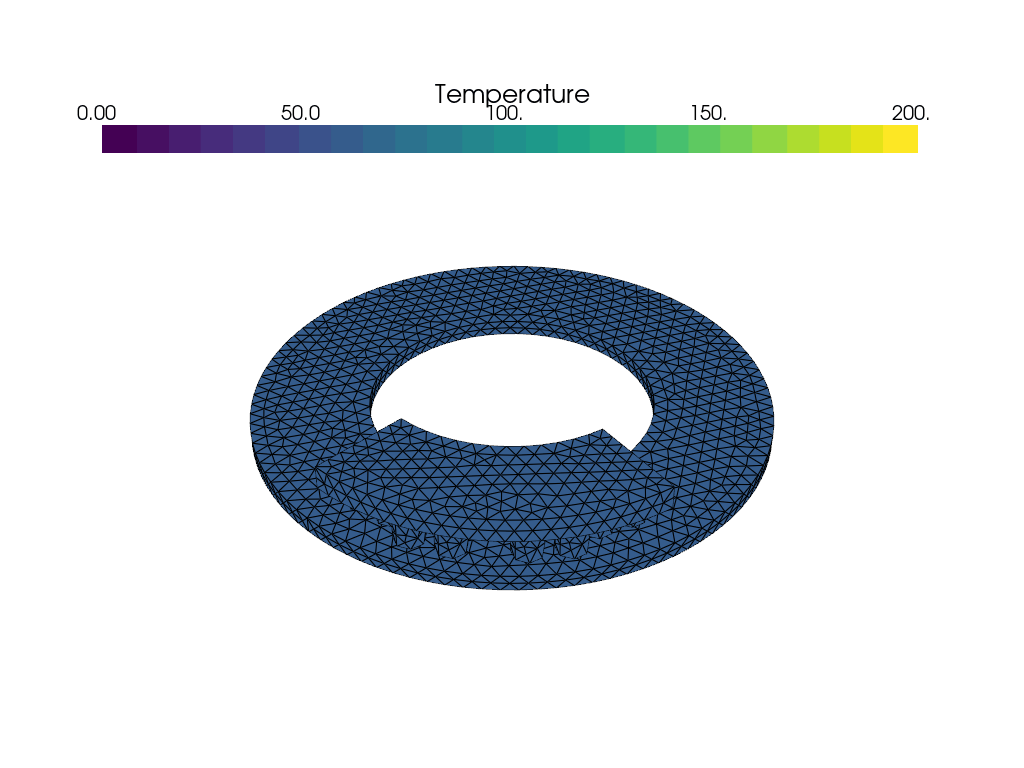

1: Start at: 2024-09-05 20:17:24
2: End at: 2024-09-05 20:23:02
3: Simulation time is 0 hours 6 minutes
4: First time step dt is 0.04046 s
5: Convection heat transfer coefficient is 7.75e-05 W/mm2 K
6: Radiation is 3.6e-13 W/mm2 K-4
7: Each rotation degree is 224 per time step or 0.6 circle
8: The first rotation degree is 977.4
9: The mid rotation degree is 977.4
10: The last rotation degree is 977.4
11: Total contact area of 18 rubbing element is 199.9 cm2
12: The mesh element size is between 3-20 mm
13: Total elements number is 8476



In [8]:
# Display the GIF
from IPython.display import display, Image

display(Image(gif_name))

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_time1 = round(elapsed_time, 0)

formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))
txt_name = "T-s-{}-d-{}-{}-c-{}-e-{}.txt".format(
    num_steps, angular_r, mesh_filename2, c_contact, total_elements
)
with open(txt_name, "w") as file:
     file.write("1: Start at: {}\n".format(formatted_start_time))
     file.write("2: End at: {}\n".format(formatted_end_time))
    
     if elapsed_time1 >= 60:
        min = elapsed_time1 / 60
        hours = min / 60
        file.write("3: Simulation time is {} hours {} minutes\n".format(round(hours), round(min)))
     else:
        file.write("3: Simulation time is {} second\n".format(elapsed_time1))
    
     file.write("4: First time step dt is {} s\n".format(round(dt[0], 5)))
     r_disc = 0.25
    
     file.write("5: Convection heat transfer coefficient is {} W/mm2 K\n".format(h))
     file.write("6: Radiation is {} W/mm2 K-4\n".format(round(radiation, 14)))
     file.write("7: Each rotation degree is {} per time step or {} circle\n".format(round(angular_r, 1), round(angular_r / 360, 1)))
     file.write("8: The first rotation degree is {}\n".format(round(v_angular[0] * r_disc * dt[0] * 1000, 1)))
     file.write("9: The mid rotation degree is {}\n".format(round(v_angular[round(num_steps / 2)] * r_disc * dt[round(len(dt) / 2)] * 1000, 1)))
     file.write("10: The last rotation degree is {}\n".format(round(v_angular[num_steps - 1] * r_disc * dt[-1] * 1000, 1)))
     file.write("11: Total contact area of 18 rubbing element is {} cm2\n".format(round(S_total / 100, 1)))
     file.write("12: The mesh element size is between {}-{} mm\n".format(mesh_min, mesh_max))
     file.write("13: Total elements number is {}\n".format(total_elements))    
   
with open(txt_name, "r") as file1:
    print(file1.read())

#### move files
# Define the source directory
source_dir = "/home/yanjun/Documents/FEniCSx/Practice/Concise"
# Define the destination directory
destination_dir = "/home/yanjun/Documents/FEM_results/python_results"

# Create the new folder in the destination directory
new_folder_name = f"s-{num_steps}-d-{angular_r}-m-{mesh_min}-{mesh_max}-c-{c_contact}-e-{total_elements}"
destination_dir = os.path.join(destination_dir, new_folder_name)
os.makedirs(destination_dir, exist_ok=True)

# List of files to move
#files_to_move = [gif_name, h5_name, xdmf_name, txt_name, csv_name]
# Move each file to the destination directory
#for filename in files_to_move:
#    source_file_path = os.path.join(source_dir, filename)
#    destination_file_path = os.path.join(destination_dir, filename)
    #shutil.move(source_file_path, destination_file_path)
#print("Move files successfully")

Lables already exists, for mesh m-3-20.msh is  [1713, 1587, 708]


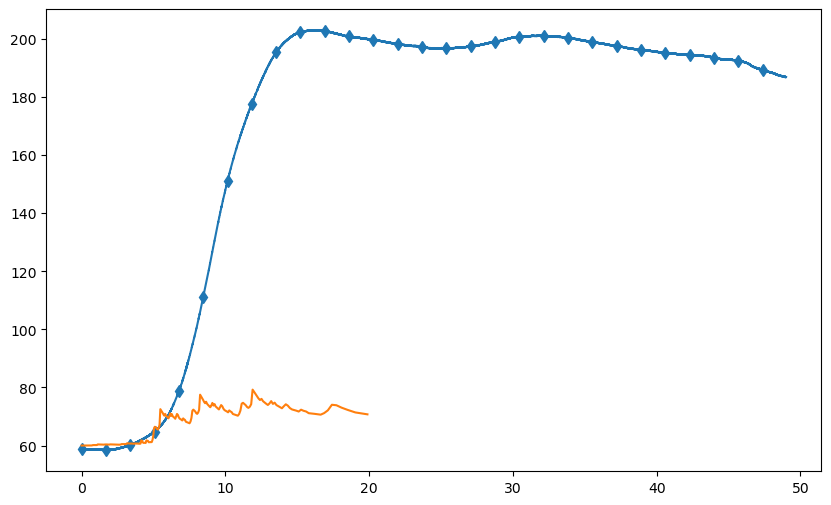

In [11]:
from disc_f import *
import pandas as pd
plt.figure(figsize=(10, 6))

df1 = pd.read_csv('/home/yanjun/documents/sim_results/experiment_result.csv')
T_e_ave = ( df1.iloc[:,1] + df1.iloc[:,3] + df1.iloc[:,5] ) /3
t_e = np.linspace (0, 49, len(T_e_ave) )
plt.plot(t_e, T_e_ave, label= "Experiment",marker='d',markevery=1000)


lables = find_3_coord(mesh_filename1)

t, T = [], []
for value in T_array:
    t.append(value[0])
    T.append(value[1])

T_3_ave = []
for i in range(len(T)):
    T_3_all = T[i][lables[0]] + T[i][lables[1]] + T[i][lables[2]]
    T_3_ave.append(T_3_all / 3)

plt.plot(t, T_3_ave)